# US Diocese Mapper

By Kenneth Burchfiel

Code released under the MIT License

(The county_shapes.csv, county_shapes.geojson, state_fips_codes.csv, and counties_by_diocese.csv files are released into in the public domain.)

The tileless maps (with a gray background) are released under the Creative Commons Attribution 4.0 license (CC-BY 4.0); I believe the ones with the OpenStreetMap background may need to be released under a more restrictive license, but I'm not sure. I would like to release those under a CC-BY 4.0 license as well if possible.

**Updates to this script:**
July 9, 2023: Revised the code and source files in order to reflect Las Vegas's elevation to an archdiocese, with Reno and Salt Lake City as suffragan dioceses. (This required changing diocese_province_list.csv, diocese_province_cathedral_list_revised.csv, and province_boundaries_revised.geojson. To update province_boundaries_revised, I deleted the older set of boundaries for San Francisco (the archdiocese to which Las Vegas, Reno, and Salt Lake City formerly belonged), then copied the new San Francisco and Las Vegas provincial boundaries stored in province_boundaries.geojson into this file.)

March 16, 2024: Switched the tile provider from Stamen Toner to OpenStreetMap due to changes in how Stamen tiles are hosted.

April 8, 2024: Added a map that doesn't contain water boundaries; this map's file size is significantly smaller than many others, thus making it easier to host on Google Sites.

# Introduction and Overview

In this notebook, I will generate a map of US Latin-rite Catholic dioceses, provinces, and cathedrals. I'll generate both interactive .HTML versions and static .PNG and .JPG versions of the map, along with several variants of the map. In order to create the map, I'll use a number of free and open-source tools and resources, including Python, Geojson.io, OpenStreetMaps, and Wikipedia.

## Preliminary steps

First, I downloaded county shapefiles from the US Census bureau here: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2021&layergroup=Counties+%28and+equivalent%29

See this note regarding use of the shapefiles: https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2021/TGRSHP2021_TechDoc_Ch1.pdf

Once you download the shapefiles to your computer, extract them using an unzipping utility. The shapefile document within this unzipped folder ends in .shp; for the 2021 county data, the file name is tl_2021_us_county.shp. 

It appears that the other files within this folder may also be used by Geopandas in the creation of GeoDataFrames, so I recommend accessing the file within the unzipped folder rather than copying it into your project folder.


Note: I used the diocese names found on https://www.usccb.org/about/bishops-and-dioceses/all-dioceses as the official names of almost all dioceses.
There are two exceptions: I use "Springfield in Massachusetts" instead of "Springfield, Massachusetts" and "St. Thomas" instead of "St. Thomas, VI."


In [1]:
import time
start_time = time.time()
import geopandas
import pandas as pd
import folium
import branca
import numpy as np
import json
from selenium import webdriver
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.chrome.options import Options
# Source: https://selenium-python.readthedocs.io/getting-started.html
import PIL.Image
import IPython
import os

simplification_level = 0.005 # This value will be passed to the tolerance
# argument within various shape simplification commands. Higher values
# produce smaller map file sizes but less accurate boundaries.

In [2]:
# Identifying the current working directory: (This directory
# will be passed as an argument to a screenshot generation function.)
cwd = os.getcwd()
cwd

'c:\\Users\\kburc\\D1V1\\Documents\\!Dell64docs\\Programming\\py\\kjb3_programs\\us_diocese_mapper'

In [3]:
generate_county_list_and_boundaries = False # This cell determines whether
# or not to create a new table of county boundaries, along with province
# and diocesan boundaries based on those county boundaries. This should be 
# set to True when generating the first batch of these boundaries or when 
# updating them; otherwise, it can generally be set to False, 
# thus saving processing time.
extract_FIPS_codes_from_website = False # Useful if working offline (or if 
# the website's layout changes in the future)

The following block converts county shapefile data into a GeoDataFrame (similar to a pandas DataFrame). In the process, it also merges in US state names by accessing a list of state FIPS codes from a government website.

In [4]:
if generate_county_list_and_boundaries == True:

    shapefile_path = \
        r'C:\Users\kburc\Downloads\tl_2021_us_county_download\tl_2021_us_county.shp'
    if extract_FIPS_codes_from_website == True:
        state_fips_codes = pd.read_html(
            'https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/technical/nra/nri/results/?cid=nrcs143_013696')[0]
        # This resource contains both FIPS codes and state names. These state
        # names will then be merged into the county_shapes DataFrame below.
        state_fips_codes = state_fips_codes.iloc[0:55].copy()
        state_fips_codes['FIPS'] = state_fips_codes['FIPS'].astype('int')
        state_fips_codes.rename(columns={'Name':'State_Name',
        'Postal Code':'State_Code'},inplace=True) 
        state_fips_codes.loc[55] = ['District of Columbia', 'DC', 11] 
        # DC wasn't present in the original webpage, so I added it in. 
        # I located its FIPS code within the county shapefile dataset.
        state_fips_codes.to_csv('state_fips_codes.csv', index = False)
    else:
        state_fips_codes = pd.read_csv('state_fips_codes.csv')

    county_shapes = geopandas.read_file(shapefile_path)

    county_shapes.drop(['CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 
    'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON'], 
    axis = 1, inplace = True)
    county_shapes['STATEFP'] = county_shapes['STATEFP'].astype('int')

    merged_county_shapes = county_shapes.merge(state_fips_codes, 
    left_on = 'STATEFP', right_on = 'FIPS', how = 'left')
    merged_county_shapes['county_state'] = merged_county_shapes[
        'NAMELSAD'] + ', ' + merged_county_shapes['State_Name']
        # The county_state column will be a valuable resource, as each entry
        # within this column is unique. (County names by themselves are not
        # unique as multiple counties can share the same name.)

    # The above line exports the GeoDataFrame created by prepare_zip_table 
    # so that it can be imported back into the program, which takes less time
    # than does recreating the GeoDataFrame.

    # merged_county_shapes.to_file('original_county_outlines.geojson')
    # This file is over 200 MB in size.

    df_dioceses = merged_county_shapes.copy()

else: # If generate_county_list_and_boundaries is set to false, the block
    # simply reads in a saved copy of df_dioceses, along with two other
    # DataFrames. (These DataFrames will get created later on if
    # generate_county_list_and_boundaries is set to True.)
    df_dioceses = geopandas.read_file('counties_by_diocese.geojson')
    diocese_boundaries = geopandas.read_file('diocese_boundaries.geojson')
    province_boundaries = geopandas.read_file('province_boundaries.geojson')


df_dioceses can be in two different formats at this point depending on whether a new copy of df_dioceses was created in the above cell. However, this will not interfere with the following code blocks.

In [5]:
df_dioceses.head(5)

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD  \
0       31      039  00835841  31039     Cuming     Cuming County   06   
1       53      069  01513275  53069  Wahkiakum  Wahkiakum County   06   
2       35      011  00933054  35011    De Baca    De Baca County   06   
3       31      109  00835876  31109  Lancaster  Lancaster County   06   
4       31      129  00835886  31129   Nuckolls   Nuckolls County   06   

   State_Name State_Code  FIPS                  county_state   Diocese  \
0    Nebraska         NE    31       Cuming County, Nebraska     Omaha   
1  Washington         WA    53  Wahkiakum County, Washington   Seattle   
2  New Mexico         NM    35    De Baca County, New Mexico  Santa Fe   
3    Nebraska         NE    31    Lancaster County, Nebraska   Lincoln   
4    Nebraska         NE    31     Nuckolls County, Nebraska   Lincoln   

  Diocese_Detail Province_Detail  Province  \
0          Omaha           Omaha     Omaha   
1        Seattle         Seattle   Seattle   
2       Santa Fe        Santa Fe  Santa Fe   
3        Lincoln           Omaha     Omaha   
4        Lincoln           Omaha     Omaha   

                                            geometry  
0  POLYGON ((-96.55551 42.08996, -96.55517 41.742...  
1  POLYGON ((-123.72656 46.38487, -123.21795 46.3...  
2  POLYGON ((-104.44494 34.69165, -104.33973 34.6...  
3  POLYGON ((-96.91094 41.04612, -96.46387 41.045...  
4  POLYGON ((-98.27357 40.35036, -97.82082 40.350...

This project will focus on dioceses in states that belong to the US Conference of Catholic Bishops. Therefore, the following code block removes counties in other regions from df_dioceses. 

In [6]:
regions_not_in_us_episcopal_conference = ['Puerto Rico', 'Guam', 
'Northern Mariana Islands', 'American Samoa']
df_dioceses = df_dioceses.query(
    "State_Name not in @regions_not_in_us_episcopal_conference").copy() 

## Matching US Counties to Dioceses

The vast majority of U.S. counties belong to a single U.S. diocese. Therefore, in order to create a first draft of my US dioceses map, I'll first assign each U.S. county to a particular diocese. 

In [7]:
df_dioceses['Diocese'] = 'Not_Set'

I'll first assign all counties in each U.S. state to a particular diocese, which will be faster than manually assigning all counties in a state to all dioceses in that state. I'll complete this operation using np.select. In order for this code to work, it's crucial that the lists of states and dioceses are in the same order.

In [8]:
condlist = [
df_dioceses['State_Name'] == 'Alabama',
df_dioceses['State_Name'] == 'Alaska',
df_dioceses['State_Name'] == 'Arizona',
df_dioceses['State_Name'] == 'Arkansas',
df_dioceses['State_Name'] == 'California',
df_dioceses['State_Name'] == 'Colorado',
df_dioceses['State_Name'] == 'Connecticut',
df_dioceses['State_Name'] == 'Delaware',
df_dioceses['State_Name'] == 'Florida',
df_dioceses['State_Name'] == 'Georgia',
df_dioceses['State_Name'] == 'Hawaii',
df_dioceses['State_Name'] == 'Idaho',
df_dioceses['State_Name'] == 'Illinois',
df_dioceses['State_Name'] == 'Indiana',
df_dioceses['State_Name'] == 'Iowa',
df_dioceses['State_Name'] == 'Kansas',
df_dioceses['State_Name'] == 'Kentucky',
df_dioceses['State_Name'] == 'Louisiana',
df_dioceses['State_Name'] == 'Maine',
df_dioceses['State_Name'] == 'Maryland',
df_dioceses['State_Name'] == 'Massachusetts',
df_dioceses['State_Name'] == 'Michigan',
df_dioceses['State_Name'] == 'Minnesota',
df_dioceses['State_Name'] == 'Mississippi',
df_dioceses['State_Name'] == 'Missouri',
df_dioceses['State_Name'] == 'Montana',
df_dioceses['State_Name'] == 'Nebraska',
df_dioceses['State_Name'] == 'Nevada',
df_dioceses['State_Name'] == 'New Hampshire',
df_dioceses['State_Name'] == 'New Jersey',
df_dioceses['State_Name'] == 'New Mexico',
df_dioceses['State_Name'] == 'New York',
df_dioceses['State_Name'] == 'North Carolina',
df_dioceses['State_Name'] == 'North Dakota',
df_dioceses['State_Name'] == 'Ohio',
df_dioceses['State_Name'] == 'Oklahoma',
df_dioceses['State_Name'] == 'Oregon',
df_dioceses['State_Name'] == 'Pennsylvania',
df_dioceses['State_Name'] == 'Rhode Island',
df_dioceses['State_Name'] == 'South Carolina',
df_dioceses['State_Name'] == 'South Dakota',
df_dioceses['State_Name'] == 'Tennessee',
df_dioceses['State_Name'] == 'Texas',
df_dioceses['State_Name'] == 'Utah',
df_dioceses['State_Name'] == 'Vermont',
df_dioceses['State_Name'] == 'Virginia',
df_dioceses['State_Name'] == 'Washington',
df_dioceses['State_Name'] == 'West Virginia',
df_dioceses['State_Name'] == 'Wisconsin',
df_dioceses['State_Name'] == 'Wyoming',
df_dioceses['State_Name'] == 'District of Columbia',
df_dioceses['State_Name'] == 'Virgin Islands'
]

I generally chose to assign all counties in a given state to the diocese that appeared to encompass the highest number of counties in that state. However, if information on which counties belonged to a given diocese was lacking, I sometimes chose to assign all counties to that diocese instead. That way, I could determine that diocese's counties by assigning all of the state's other counties to its other dioceses.

In [9]:
choicelist = [

# To make sure that I had the dioceses and states in the same order, I copied
# and pasted the state list into this code block, then commented it out so 
# that it could be used as a reference.

# df_dioceses['State_Name'] == 'Alabama',
'Mobile',

# df_dioceses['State_Name'] == 'Alaska',
'Fairbanks',

# df_dioceses['State_Name'] == 'Arizona',
'Phoenix',

# df_dioceses['State_Name'] == 'Arkansas',
'Little Rock', # Statewide diocese

# df_dioceses['State_Name'] == 'California',
'Los Angeles', 

# df_dioceses['State_Name'] == 'Colorado',
'Pueblo',

# df_dioceses['State_Name'] == 'Connecticut',
'Norwich', 

# df_dioceses['State_Name'] == 'Delaware',
'Wilmington', # Statewide diocese

# df_dioceses['State_Name'] == 'Florida',
'Orlando', 

# df_dioceses['State_Name'] == 'Georgia',
'Savannah',

# df_dioceses['State_Name'] == 'Hawaii',
'Honolulu', # Statewide diocese

# df_dioceses['State_Name'] == 'Idaho',
'Boise', #Statewide diocese

# df_dioceses['State_Name'] == 'Illinois',
'Peoria',

# df_dioceses['State_Name'] == 'Indiana',
'Indianapolis', 

# df_dioceses['State_Name'] == 'Iowa',
'Dubuque',

# df_dioceses['State_Name'] == 'Kansas',
'Salina',

# df_dioceses['State_Name'] == 'Kentucky',
'Lexington',

# df_dioceses['State_Name'] == 'Louisiana',
'Shreveport',

# df_dioceses['State_Name'] == 'Maine',
'Portland in Maine', # Statewide diocese

# df_dioceses['State_Name'] == 'Maryland',
'Wilmington', 

# df_dioceses['State_Name'] == 'Massachusetts',
'Boston',

# df_dioceses['State_Name'] == 'Michigan',
'Marquette',

# df_dioceses['State_Name'] == 'Minnesota',
'Duluth',

# df_dioceses['State_Name'] == 'Mississippi',
'Jackson',

# df_dioceses['State_Name'] == 'Missouri',
'Springfield-Cape Girardeau',

# df_dioceses['State_Name'] == 'Montana',
'Helena',

# df_dioceses['State_Name'] == 'Nebraska',
'Grand Island',

# df_dioceses['State_Name'] == 'Nevada',
'Reno',

# df_dioceses['State_Name'] == 'New Hampshire',
'Manchester', # Statewide diocese

# df_dioceses['State_Name'] == 'New Jersey',
'Camden',

# df_dioceses['State_Name'] == 'New Mexico',
'Santa Fe',

# df_dioceses['State_Name'] == 'New York',
'Albany',

# df_dioceses['State_Name'] == 'North Carolina',
'Raleigh',

# df_dioceses['State_Name'] == 'North Dakota',
'Fargo',

# df_dioceses['State_Name'] == 'Ohio',
'Columbus',

# df_dioceses['State_Name'] == 'Oklahoma',
'Oklahoma City',

# df_dioceses['State_Name'] == 'Oregon',
'Portland in Oregon',

# df_dioceses['State_Name'] == 'Pennsylvania',
'Erie',

# df_dioceses['State_Name'] == 'Rhode Island',
'Providence', #Statewide diocese

# df_dioceses['State_Name'] == 'South Carolina',
'Charleston', # Statewide diocese

# df_dioceses['State_Name'] == 'South Dakota',
'Sioux Falls',

# df_dioceses['State_Name'] == 'Tennessee',
'Nashville',

# df_dioceses['State_Name'] == 'Texas',
'Lubbock',

# df_dioceses['State_Name'] == 'Utah',
'Salt Lake City', # Statewide Diocese

# df_dioceses['State_Name'] == 'Vermont',
'Burlington', # Statewide diocese

# df_dioceses['State_Name'] == 'Virginia',
'Richmond',

# df_dioceses['State_Name'] == 'Washington',
'Seattle',

# df_dioceses['State_Name'] == 'West Virginia',
'Wheeling-Charleston', # Statewide diocese

# df_dioceses['State_Name'] == 'Wisconsin',
'La Crosse',

# df_dioceses['State_Name'] == 'Wyoming'],
'Cheyenne', # Statewide diocese

# df_dioceses['State_Name'] == 'District of Columbia',
'Washington',

# df_dioceses['State_Name'] == 'Virgin Islands'
'St. Thomas'
]

In [10]:
df_dioceses['Diocese'] = np.select(condlist, choicelist, df_dioceses['Diocese'])
# https://numpy.org/doc/stable/reference/generated/numpy.select.html

In [11]:
len(df_dioceses) # The number of counties within the DataFrame

3146

Currently, all counties within a given state are assigned to the same diocese in the 'Diocese' column. (If df_dioceses was loaded in from a saved file, it will also contain a 'Diocese_Detail' column with the actual diocese(s) to which that county belongs. This column will be created and/or modified later.)

In [12]:
df_dioceses

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD  \
0          31      039  00835841  31039     Cuming     Cuming County   06   
1          53      069  01513275  53069  Wahkiakum  Wahkiakum County   06   
2          35      011  00933054  35011    De Baca    De Baca County   06   
3          31      109  00835876  31109  Lancaster  Lancaster County   06   
4          31      129  00835886  31129   Nuckolls   Nuckolls County   06   
...       ...      ...       ...    ...        ...               ...  ...   
3141       13      123  00351260  13123     Gilmer     Gilmer County   06   
3142       27      135  00659513  27135     Roseau     Roseau County   06   
3143       28      089  00695768  28089    Madison    Madison County   06   
3144       48      227  01383899  48227     Howard     Howard County   06   
3145       54      099  01550056  54099      Wayne      Wayne County   06   

         State_Name State_Code  FIPS                  county_state  \
0          Nebraska         NE    31       Cuming County, Nebraska   
1        Washington         WA    53  Wahkiakum County, Washington   
2        New Mexico         NM    35    De Baca County, New Mexico   
3          Nebraska         NE    31    Lancaster County, Nebraska   
4          Nebraska         NE    31     Nuckolls County, Nebraska   
...             ...        ...   ...                           ...   
3141        Georgia         GA    13        Gilmer County, Georgia   
3142      Minnesota         MN    27      Roseau County, Minnesota   
3143    Mississippi         MS    28   Madison County, Mississippi   
3144          Texas         TX    48          Howard County, Texas   
3145  West Virginia         WV    54   Wayne County, West Virginia   

                  Diocese       Diocese_Detail           Province_Detail  \
0            Grand Island                Omaha                     Omaha   
1                 Seattle              Seattle                   Seattle   
2                Santa Fe             Santa Fe                  Santa Fe   
3            Grand Island              Lincoln                     Omaha   
4            Grand Island              Lincoln                     Omaha   
...                   ...                  ...                       ...   
3141             Savannah              Atlanta                   Atlanta   
3142               Duluth            Crookston  St. Paul and Minneapolis   
3143              Jackson              Jackson                    Mobile   
3144              Lubbock           San Angelo               San Antonio   
3145  Wheeling-Charleston  Wheeling-Charleston                 Baltimore   

                      Province  \
0                        Omaha   
1                      Seattle   
2                     Santa Fe   
3                        Omaha   
4                        Omaha   
...                        ...   
3141                   Atlanta   
3142  St. Paul and Minneapolis   
3143                    Mobile   
3144               San Antonio   
3145                 Baltimore   

                                               geometry  
0     POLYGON ((-96.55551 42.08996, -96.55517 41.742...  
1     POLYGON ((-123.72656 46.38487, -123.21795 46.3...  
2     POLYGON ((-104.44494 34.69165, -104.33973 34.6...  
3     POLYGON ((-96.91094 41.04612, -96.46387 41.045...  
4     POLYGON ((-98.27357 40.35036, -97.82082 40.350...  
...                                                 ...  
3141  POLYGON ((-84.19389 34.63883, -84.65437 34.548...  
3142  POLYGON ((-95.30104 48.90422, -95.09146 48.920...  
3143  POLYGON ((-90.06412 32.39989, -90.44978 32.487...  
3144  POLYGON ((-101.17457 32.52411, -101.18400 32.0...  
3145  POLYGON ((-82.30265 38.29912, -82.19231 38.046...  

[3146 rows x 16 columns]

In [13]:
initial_version_of_df_dioceses = \
df_dioceses.copy() # Will be compared to a later version of df_dioceses

It's now time to assign the counties in df_dioceses to their actual dioceses. To speed this process up, I'll define a function below that will allow me to simultaneously assign a list of counties to a given diocese.

In [14]:
def add_dioceses(df, county_list, state, diocese):
    # Updates the 'Diocese' value within df_dioceses for a list 
    # of counties in a given state. If a diocese spans
    # multiple states, this function will need to be called once for each
    # state.
    # If a given 'county' variable does not have any spaces, 
    # the loop below will add ' County' to that string before 
    # adding in the state. Otherwise, the code assumes that the 'county' is
    # either a non-county (e.g. a municipality, city, census area, parish,
    # or borough), and will only add the state to this string.
    # Therefore, in order to run this function successfully, enter the 
    # area designation (county, city, etc.) after all non-counties and
    # counties with more than one word when building the county list.
    # However, you don't need to add in 'County' for counties with only
    # one word.
    for county in county_list:
        if ' ' not in county:
            county_string = county + ' County, ' + state
        else:
            county_string = county + ', ' + state
        if county_string not in df.index:
            raise ValueError(county_string, "not found in index")
        df.at[county_string, 'Diocese'] = diocese
        # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.at.html
        # df.at updates the 'Diocese' value for a given county_string. For 
        # this function to work, the DataFrame's index must be set to 
        # county_string.
    return df




## Assigning Dioceses' Counties to Those Dioceses

The following loooooong code block uses add_dioceses() to update the diocese listings for most counties in the US. (Some counties are already assigned to their correct diocese, so those won't need to be modified here.)

Writing this code block required me to determine which counties belonged to which U.S. diocese. I relied mostly on Wikipedia for this information, although I also referenced diocesan websites where needed. Wikipedia pages for different dioceses sometimes disagreed with one another regarding diocesan county affiliation, and this even proved to be the case for some diocesan websites also. Therefore, the county listings created by this code block may be inaccurate at times.

I also learned through this process that some counties are in multiple dioceses and even multiple provinces. Within this code block, I resolved this issue by assigning those counties to the dioceses that appeared to encompass the largest proportion of the counties, but this was only a temporary fix. Later on, I edited the diocesan and provincial boundaries using geojson.io to make them more accurate. 

I also relied on the following listing of U.S. dioceses: 
https://en.wikipedia.org/wiki/List_of_Catholic_dioceses_in_the_United_States


In [15]:
df_dioceses.set_index('county_state', drop = False, inplace = True) # This 
# temporary change is made to facilitate the use of df.at within the 
# add_dioceses function. The county_state column is retained for later use.

# Archdiocese of Anchorage-Juneau:
# Source: Wikipedia province map

anchorage_juneau_county_list = [
'Aleutians West Census Area',
'Aleutians East Borough', 'Lake and Peninsula Borough',
'Bristol Bay Borough', 'Dillingham Census Area', 'Kodiak Island Borough',
'Kenai Peninsula Borough', 'Chugach Census Area', 'Yakutat City and Borough',
'Aleutians West Census Area', 'Hoonah-Angoon Census Area',
'Petersburg Borough', 'Wrangell City and Borough', 'Ketchikan Gateway Borough',
'Prince of Wales-Hyder Census Area', 'Sitka City and Borough',
'Copper River Census Area', 'Matanuska-Susitna Borough',
'Anchorage Municipality', 'Juneau City and Borough', 'Skagway Municipality',
'Haines Borough'
]
# In the following line of code, add_dioceses will go through each county
# (or, in this case, county equivalent) in anchorage_juneau_county list
# and set its 'Diocese' value within df_dioceses to Anchorage-Juneau. 
df_dioceses = add_dioceses(df_dioceses, 
anchorage_juneau_county_list, state = 'Alaska', diocese = 'Anchorage-Juneau')

# Archdiocese of Atlanta:
# (Source: Diocesan website: 
# https://archatl.com/about/about-the-archdiocese-of-atlanta/)
# This site noted the counties within the Archdiocese of Atlanta that border
# the Diocese of Savannah. I entered in those counties first, then added in
# all other counties to the north of those.

atlanta_county_list = [
'Gilmer', 'Carroll', 'Douglas', 'Clayton', 'Spalding', 'Henry', 'Rockdale',
'Oconee', 'Barrow', 'Jackson', 'Madison', 'Elbert', 'Rabun', 'Towns',
'Union', 'Fannin', 'Murray', 'Catoosa', 'Whitfield', 'Dade', 'Walker',
'Chattooga', 'Gordon', 'Pickens', 'Dawson', 'Lumpkin', 'White', 'Habersham',
'Stephens', 'Hart', 'Franklin', 'Banks', 'Hall', 'Forsyth', 'Fulton',
'Cherokee', 'Bartow', 'Floyd', 'Polk', 'Haralson', 'Paulding', 'Cobb',
'DeKalb', 'Gwinnett', 'Walton', 'Clarke', 'Oglethorpe', 'Coweta', 'Wilkes',
'Coweta', 'Taliaferro', 'Greene', 'Morgan', 'Coweta', 'Newton', 'Butts', 
'Lamar', 'Pike', 'Coweta', 'Fayette', 'Coweta', 'Heard', 'Troup', 'Meriwether',
'Upson', 'Monroe', 'Jasper', 'Putnam', 'Baldwin', 'Hancock', 'Warren',
'McDuffie', 'Lincoln'
]
df_dioceses = add_dioceses(df_dioceses, 
atlanta_county_list, state = 'Georgia', diocese = 'Atlanta')

# # Diocese of Charlotte:
# Source: https://web.archive.org/web/20110504140939/http://www.charlottediocese.org/atlasofthediocese.html 
# See also:
# https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Charlotte#/media/File:Diocese_of_Charlotte.jpg

charlotte_county_list = [
'Richmond', 'Montgomery', 'Randolph', 'Guilford', 'Rockingham', 'Mecklenburg', 
'Davie', 'Yadkin', 'Surry', 'Alleghany', 'Wilkes', 'Iredell', 'Catawba', 
'Lincoln', 'Gaston', 'Cleveland', 'Stokes', 'Forsyth', 'Davidson', 'Rowan', 
'Stanly', 'Anson', 'Union', 'Cabarrus', 'Cherokee', 'Graham', 'Swain', 
'Haywood', 'Madison', 'Ashe', 'Watauga', 'Caldwell', 'Alexander', 'Burke', 
'McDowell', 'Rutherford', 'Polk', 'Henderson', 'Buncombe', 'Yancey', 'Mitchell', 
'Clay', 'Macon', 'Jackson', 'Transylvania', 'Avery'
]
df_dioceses = add_dioceses(df_dioceses, 
charlotte_county_list, state = 'North Carolina', diocese = 'Charlotte')

# Archdiocese of Baltimore:
# https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_Baltimore

baltimore_county_list = [
'Anne Arundel County', 'Baltimore', 'Carroll', 'Frederick', 'Garrett', 
'Harford', 'Howard', 'Washington', 'Baltimore city','Allegany'
] 
df_dioceses = add_dioceses(df_dioceses, 
baltimore_county_list, state = 'Maryland', diocese = 'Baltimore')

# Diocese of Arlington:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Arlington

arlington_county_list = [
'Arlington', 'Clarke', 'Culpeper', 'Fairfax', 'Fauquier', 'Frederick', 
'King George County', 'Lancaster', 'Loudoun', 'Madison', 'Northumberland', 
'Orange', 'Page', 'Prince William County', 'Rappahannock', 'Richmond',
'Shenandoah', 'Spotsylvania', 'Stafford', 'Warren', 'Westmoreland', 
'Alexandria city', 'Falls Church city', 'Fairfax city', 'Fredericksburg city',
'Manassas city', 'Manassas Park city', 'Winchester city'
]
df_dioceses = add_dioceses(df_dioceses, 
arlington_county_list, state = 'Virginia', diocese = 'Arlington')

# Archdiocese of Washington:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_Washington
# Note that the Archdiocese of Washington includes a number of counties
# in Maryland, which will be added here. The District of Columbia is already
# listed as belonging to the Diocese of Washington.
washington_county_list = [
'Calvert', 'Charles', 'Montgomery', 
"Prince George's County", "St. Mary's County"
]
df_dioceses = add_dioceses(df_dioceses, 
washington_county_list, state = 'Maryland', diocese = 'Washington')


# Diocese of Fall River:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Fall_River

fall_river_county_list = [
'Barnstable', 'Bristol', 'Dukes', 'Nantucket'
]
df_dioceses = add_dioceses(df_dioceses, 
fall_river_county_list, state = 'Massachusetts', diocese = 'Fall River')

# Diocese of Springfield in Massachusetts:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Springfield_in_Massachusetts

springfield_in_massachusetts_county_list = [
'Berkshire', 'Franklin', 'Hampshire', 'Hampden'
]
df_dioceses = add_dioceses(df_dioceses, 
springfield_in_massachusetts_county_list, state = 'Massachusetts', diocese = 
'Springfield in Massachusetts')

# Diocese of Worcester: 
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Worcester

df_dioceses.at[
"Worcester County, Massachusetts", 'Diocese'] = 'Worcester' 
# The Diocese of Worcester includes only one county, so it can
# be added directly to the DataFrame.

# Archdiocese of Chicago: 
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_Chicago

chicago_county_list = [
'Cook', 'Lake'
]
df_dioceses = add_dioceses(df_dioceses, 
chicago_county_list, state = 'Illinois', diocese = 
'Chicago')

# Diocese of Belleville:
# I couldn't find a list of counties on the diocese's website
# or on the Diocese's Wikipedia page, so I based the county
# list off this map:
# https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Belleville#/media/File:Diocese_of_Belleville_map_1.png

belleville_county_list = [
"St. Clair County", "Clinton", "Marion", "Clay", "Richland", "Lawrence", 
"Wabash", "Edwards", "Wayne", "Monroe", "Washington", "Jefferson", "Hamilton", 
"White", "Gallatin", "Saline", "Williamson", "Jackson", "Union", "Johnson", 
"Pope", "Massac", "Pulaski", "Alexander", "Randolph", "Perry", "Franklin", 
"Hardin"
]
df_dioceses = add_dioceses(df_dioceses, 
belleville_county_list, state = 'Illinois', diocese = 
'Belleville')

# Diocese of Joliet:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Joliet_in_Illinois

joliet_county_list = [
"DuPage", "Ford", "Grundy", "Iroquois", "Kankakee", "Kendall", "Will"
]
df_dioceses = add_dioceses(df_dioceses, 
joliet_county_list, state = 'Illinois', diocese = 
'Joliet')

# Diocese of Rockford:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Rockford

rockford_county_list = [
"Boone", "Carroll", "DeKalb", "Jo Daviess County", "Kane", "Lee", "McHenry",
"Ogle", "Stephenson", "Whiteside", "Winnebago"
]
df_dioceses = add_dioceses(df_dioceses, 
rockford_county_list, state = 'Illinois', diocese = 
'Rockford')

springfield_in_illinois_county_list = [
"Adams", "Bond", "Brown", "Calhoun", "Cass", "Christian", "Clark", "Coles", 
"Crawford", "Cumberland", "Douglas", "Edgar", "Effingham", "Fayette", "Greene", 
"Jasper", "Jersey", "Macon", "Macoupin", "Madison", "Menard", "Moultrie", 
"Montgomery", "Morgan", "Pike", "Sangamon", "Scott", "Shelby"
]
df_dioceses = add_dioceses(df_dioceses, 
springfield_in_illinois_county_list, state = 'Illinois', diocese = 
'Springfield in Illinois')

# Archdiocese of Cincinnati:
# Source: https://catholicaoc.org/about/geography

cincinnati_county_list = [
'Mercer', 'Auglaize', 'Logan', 'Darke', 'Shelby', 'Miami', 'Clark', 'Preble', 
'Montgomery', 'Greene', 'Butler', 'Warren', 'Clinton', 'Hamilton', 'Clermont', 
'Brown', 'Highland', 'Adams', 'Champaign'
]
df_dioceses = add_dioceses(df_dioceses, 
cincinnati_county_list, state = 'Ohio', diocese = 
'Cincinnati')

# Diocese of Cleveland: 
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Cleveland
cleveland_county_list = [
'Ashland', 'Cuyahoga', 'Geauga', 'Lake', 'Lorain',
'Medina', 'Summit', 'Wayne'
]
df_dioceses = add_dioceses(df_dioceses, 
cleveland_county_list, state = 'Ohio', diocese = 
'Cleveland')

# Diocese of Steubenville:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Steubenville
steubenville_county_list = [
'Athens', 'Belmont', 'Carroll', 'Gallia', 'Guernsey', 'Harrison', 'Jefferson', 
'Lawrence', 'Meigs', 'Morgan', 'Monroe', 'Noble', 'Washington'
]
df_dioceses = add_dioceses(df_dioceses, 
steubenville_county_list, state = 'Ohio', diocese = 
'Steubenville')

# Diocese of Toledo:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Toledo

toledo_county_list = [
'Allen', 'Crawford', 'Defiance', 'Erie', 'Fulton',
'Hancock', 'Henry', 'Huron', 'Lucas', 'Ottawa', 'Paulding', 'Putnam', 
'Richland', 'Sandusky', 'Seneca', 'Van Wert County', 'Williams', 'Wood',
'Wyandot'
]
df_dioceses = add_dioceses(df_dioceses, 
toledo_county_list, state = 'Ohio', diocese = 
'Toledo')

# Diocese of Youngstown:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Youngstown

youngstown_county_list = [
'Mahoning', 'Trumbull', 'Columbiana', 'Stark', 'Portage', 'Ashtabula'
]
df_dioceses = add_dioceses(df_dioceses, 
youngstown_county_list, state = 'Ohio', diocese = 
'Youngstown')

# Archdiocese of Denver:
# Source: https://archden.org/wp-content/uploads/2021/11/2021_media_kit_updated_11-3-21.pdf
# This source incorrectly spells Broomfield County as 
# 'Bromfield.' 

denver_county_list = [
'Adams', 'Arapahoe', 'Boulder', 'Broomfield', 
'Clear Creek County', 'Denver', 'Eagle', 'Garfield',
'Gilpin', 'Grand', 'Jackson', 'Jefferson', 'Larimer',
'Logan', 'Moffat', 'Morgan', 'Phillips', 'Pitkin',
'Rio Blanco County', 'Routt', 'Sedgwick', 'Summit',
'Washington', 'Weld', 'Yuma'
]
df_dioceses = add_dioceses(df_dioceses, 
denver_county_list, state = 'Colorado', diocese = 
'Denver')


# Diocese of Colorado Springs:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Colorado_Springs

colorado_springs_county_list = [
'Chaffee', 'Lake', 'Park', 'Teller', 'Douglas',
'El Paso County', 'Elbert', 'Lincoln', 
'Kit Carson County', 'Cheyenne'
]
df_dioceses = add_dioceses(df_dioceses, 
colorado_springs_county_list, state = 'Colorado', diocese = 
'Colorado Springs')

# Archdiocese of Detroit:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_Detroit

detroit_county_list = [
'Lapeer', 'Macomb', 'Monroe', 'Oakland', 'St. Clair County', 'Wayne'
]
df_dioceses = add_dioceses(df_dioceses, 
detroit_county_list, state = 'Michigan', diocese = 
'Detroit')


# Diocese of Gaylord:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Gaylord

gaylord_county_list = [
'Charlevoix', 'Emmet', 'Cheboygan', 'Presque Isle County', 
'Leelanau', 'Antrim', 'Otsego', 'Montmorency', 'Alpena', 'Benzie', 
'Grand Traverse County', 'Kalkaska', 'Crawford', 'Oscoda', 'Alcona',
'Manistee', 'Wexford', 'Missaukee', 'Roscommon', 'Ogemaw', 'Iosco'
]
df_dioceses = add_dioceses(df_dioceses, 
gaylord_county_list, state = 'Michigan', diocese = 
'Gaylord')

# Diocese of Grand Rapids:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Grand_Rapids

grand_rapids_county_list = [
'Ottawa', 'Kent', 'Ionia', 'Muskegon', 'Newaygo', 'Oceana', 
'Montcalm', 'Mecosta', 'Lake', 'Mason', 'Osceola'
]
df_dioceses = add_dioceses(df_dioceses, 
grand_rapids_county_list, state = 'Michigan', diocese = 
'Grand Rapids')


# Diocese of Kalamazoo:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Kalamazoo
kalamazoo_county_list = [
'Allegan', 'Barry', 'Van Buren County', 'Kalamazoo', 'Calhoun', 
'Berrien', 'Cass', 'St. Joseph County', 'Branch'
]
df_dioceses = add_dioceses(df_dioceses, 
kalamazoo_county_list, state = 'Michigan', diocese = 
'Kalamazoo')

# Diocese of Lansing:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Lansing

lansing_county_list = [
'Clinton', 'Eaton', 'Genesee', 'Hillsdale', 'Ingham', 'Jackson', 
'Lenawee', 'Livingston', 'Shiawassee', 'Washtenaw'
]
df_dioceses = add_dioceses(df_dioceses, 
lansing_county_list, state = 'Michigan', diocese = 
'Lansing')


# Diocese of Saginaw:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Saginaw
saginaw_county_list = [
'Arenac', 'Bay', 'Clare', 'Gladwin', 'Gratiot', 'Huron', 'Isabella',
'Midland', 'Saginaw', 'Sanilac', 'Tuscola']

df_dioceses = add_dioceses(df_dioceses, 
saginaw_county_list, state = 'Michigan', diocese = 
'Saginaw')

# Diocese of Davenport:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Davenport
# See also:
# https://d2y1pz2y630308.cloudfront.net/13543/documents/2020/8/Parishes%20Map%207-1-20.pdf
davenport_county_list = [
'Jasper', 'Poweshiek', 'Iowa', 'Johnson', 'Cedar', 'Clinton', 'Marion',
'Monroe', 'Appanoose', 'Mahaska', 'Wapello', 'Davis', 'Keokuk', 
'Washington', 'Muscatine', 'Scott', 'Louisa', 'Des Moines County', 
'Henry', 'Lee', 'Van Buren County', 'Jefferson']

df_dioceses = add_dioceses(df_dioceses, 
davenport_county_list, state = 'Iowa', diocese = 
'Davenport')

# Diocese of Sioux CIty:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Sioux_City#/media/File:Diocese_of_Sioux_City.jpg

sioux_city_county_list = [
'Boone', 'Greene', 'Carroll', 'Crawford', 'Monona', 'Webster', 'Humboldt', 
'Kossuth', 'Dickinson', 'Lyon', 'Sioux', 'Plymouth', 'Woodbury', 'Osceola',
'Emmet', "O'Brien", 'Clay', 'Palo Alto County', 'Cherokee', 
'Buena Vista County', 'Pocahontas', 'Ida', 'Sac', 'Calhoun'
]
df_dioceses = add_dioceses(df_dioceses, 
sioux_city_county_list, state = 'Iowa', diocese = 
'Sioux City')

# Diocese of Des Moines:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Des_Moines#/media/File:Diocese_of_Des_Moines.jpg

des_moines_county_list = [
'Harrison', 'Shelby', 'Audubon', 'Guthrie', 'Dallas', 'Polk',
'Pottawattamie', 'Cass', 'Adair', 'Madison', 'Warren', 'Mills',
'Montgomery', 'Adams', 'Union', 'Clarke', 'Lucas', 'Fremont',
'Page', 'Taylor', 'Ringgold', 'Decatur', 'Wayne'
]
df_dioceses = add_dioceses(df_dioceses, 
des_moines_county_list, state = 'Iowa', diocese = 
'Des Moines')

# Archdiocese of Galveston-Houston:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_Galveston%E2%80%93Houston
galveston_houston_county_list = [
'Galveston', 'Harris', 'Austin', 'Brazoria', 'Fort Bend County', 'Grimes',
'Montgomery', 'San Jacinto County', 'Walker', 'Waller'] 

df_dioceses = add_dioceses(df_dioceses, 
galveston_houston_county_list, state = 'Texas', diocese = 
'Galveston-Houston')


# Diocese of Austin:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Austin
austin_county_list = [
'Bastrop', 'Bell', 'Blanco', 'Brazos', 'Burleson', 'Burnet', 'Caldwell',
'Coryell', 'Falls', 'Hamilton', 'Hays', 'Lampasas', 'Lee', 'Limestone',
'Llano', 'Mason', 'McLennan', 'Milam', 'Mills', 'Robertson', 'San Saba County',
'Travis', 'Washington', 'Williamson'
]

df_dioceses = add_dioceses(df_dioceses, 
austin_county_list, state = 'Texas', diocese = 
'Austin')

# Diocese of Beaumont:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Beaumont

beaumont_county_list = [
'Chambers', 'Hardin', 'Jasper', 'Jefferson', 'Liberty', 'Newton', 'Orange',
'Polk', 'Tyler'
]
df_dioceses = add_dioceses(df_dioceses, 
beaumont_county_list, state = 'Texas', diocese = 
'Beaumont')

# Diocese of Brownsville:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Brownsville
brownsville_county_list = [
'Starr', 'Willacy', 'Hidalgo', 'Cameron'
]
df_dioceses = add_dioceses(df_dioceses, 
brownsville_county_list, state = 'Texas', diocese = 
'Brownsville')

# Diocese of Corpus Christi:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Corpus_Christi

corpus_christi_county_list = [
'Aransas', 'Bee', 'Brooks', 'Duval', 'Jim Wells County', 'Kenedy', 'Kleberg', 
'Live Oak County', 'Nueces', 'Refugio', 'San Patricio County'
]
df_dioceses = add_dioceses(df_dioceses, 
corpus_christi_county_list, state = 'Texas', diocese = 
'Corpus Christi')

# Diocese of Tyler:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Tyler

tyler_county_list = ['Anderson', 'Angelina', 'Bowie', 'Camp', 'Cass',
'Cherokee', 'Delta', 'Franklin', 'Freestone', 'Gregg', 'Harrison',
'Henderson', 'Hopkins', 'Houston', 'Lamar', 'Leon', 'Madison', 'Marion', 
'Morris', 'Nacogdoches', 'Panola', 'Rains', 'Red River County', 'Rusk', 
'Sabine', 'San Augustine County', 'Shelby', 'Smith', 'Titus', 'Trinity', 
'Upshur', 'Van Zandt County', 'Wood']

df_dioceses = add_dioceses(df_dioceses, 
tyler_county_list, state = 'Texas', diocese = 
'Tyler')

# Diocese of Victoria:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Victoria_in_Texas

victoria_in_texas_county_list = [
'Calhoun', 'Colorado', 'DeWitt', 'Fayette', 'Goliad', 'Jackson', 'Lavaca', 
'Matagorda', 'Victoria', 'Wharton'
] 
df_dioceses = add_dioceses(df_dioceses, 
victoria_in_texas_county_list, state = 'Texas', diocese = 
'Victoria in Texas')

# Archddiocese of San Antonio:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_San_Antonio

san_antonio_county_list = [
'Val Verde County', 'Edwards', 'Kerr', 'Gillespie', 'Kendall', 'Comal',
'Guadalupe', 'Gonzales', 'Uvalde', 'Bandera', 'Real', 'Kinney', 'Medina', 
'Bexar', 'Wilson', 'Karnes', 'Frio', 'Atascosa', 'McMullen'
]
df_dioceses = add_dioceses(df_dioceses, 
san_antonio_county_list, state = 'Texas', diocese = 
'San Antonio')

# Diocese of Amarillo:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Amarillo

amarillo_county_list = [
'Armstrong', 'Briscoe', 'Carson', 'Castro', 'Childress', 'Collingsworth', 
'Dallam', 'Deaf Smith County', 'Donley', 'Gray', 'Hall', 'Hansford', 'Hartley',
'Hemphill', 'Hutchinson', 'Lipscomb', 'Moore', 'Ochiltree', 'Oldham', 'Parmer',
'Potter', 'Randall', 'Roberts', 'Sherman', 'Swisher', 'Wheeler'
]
df_dioceses = add_dioceses(df_dioceses, 
amarillo_county_list, state = 'Texas', diocese = 
'Amarillo')

# Diocese of Dallas:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Dallas

dallas_county_list = [
'Collin', 'Dallas', 'Ellis', 'Fannin', 'Grayson', 'Hunt', 'Kaufman', 'Navarro',
'Rockwall'
]
df_dioceses = add_dioceses(df_dioceses, 
dallas_county_list, state = 'Texas', diocese = 
'Dallas')

# Diocese of El Paso:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_El_Paso
el_paso_county_list = [
'El Paso County', 'Brewster', 'Culberson', 'Hudspeth', 'Jeff Davis County',
'Loving', 'Presidio', 'Reeves', 'Ward', 'Winkler'
] 
df_dioceses = add_dioceses(df_dioceses, 
el_paso_county_list, state = 'Texas', diocese = 
'El Paso')

# Diocese of Fort Worth:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Fort_Worth

fort_worth_county_list = [
'Archer', 'Baylor', 'Bosque', 'Clay', 'Comanche', 'Cooke', 'Denton', 'Eastland',
'Erath', 'Foard', 'Hardeman', 'Hill', 'Hood', 'Jack', 'Johnson', 'Knox', 
'Montague', 'Palo Pinto County', 'Parker', 'Shackelford', 'Somervell', 
'Stephens', 'Tarrant', 'Throckmorton', 'Wichita', 'Wilbarger', 'Wise', 'Young'
]
df_dioceses = add_dioceses(df_dioceses, 
fort_worth_county_list, state = 'Texas', diocese = 
'Fort Worth')

# Diocese of Laredo:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Laredo

laredo_county_list = [
'Dimmit', 'Jim Hogg County', 'La Salle County', 'Maverick', 'Webb', 'Zapata', 
'Zavala']
df_dioceses = add_dioceses(df_dioceses, 
laredo_county_list, state = 'Texas', diocese = 
'Laredo')

# Diocese of San Angelo:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_San_Angelo

san_angelo_county_list = [
'Andrews', 'Brown', 'Callahan', 'Coke', 'Coleman', 'Concho', 'Crane', 
'Crockett', 'Ector', 'Glasscock', 'Howard', 'Irion', 'Kimble', 'Martin', 
'McCulloch', 'Menard', 'Midland', 'Mitchell', 'Nolan', 'Pecos', 'Reagan',
'Runnels', 'Schleicher', 'Sterling', 'Sutton', 'Taylor', 'Terrell', 
'Tom Green County', 'Upton'
]
df_dioceses = add_dioceses(df_dioceses, 
san_angelo_county_list, state = 'Texas', diocese = 
'San Angelo')

# Archdiocese of Hartford:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_Hartford

hartford_county_list = [
'Hartford', 'Litchfield', 'New Haven County'
]

df_dioceses = add_dioceses(df_dioceses, 
hartford_county_list, state = 'Connecticut', diocese = 
'Hartford')

# Diocese of Bridgeport:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Bridgeport

df_dioceses.at[
"Fairfield County, Connecticut", 'Diocese'] = 'Bridgeport' 
# The Diocese of Bridgeport includes only one county, so it can
# be added directly to the DataFrame.

# Diocese of Evansville:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Evansville
evansville_county_list = ['Warrick', 'Greene', 'Knox', 'Sullivan', 'Daviess', 
'Martin', 'Dubois', 'Spencer', 'Gibson', 'Pike', 'Posey', 'Vanderburgh']
df_dioceses = add_dioceses(df_dioceses, 
evansville_county_list, state = 'Indiana', diocese = 
'Evansville')


# Diocese of Fort Wayne-South Bend:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Fort_Wayne%E2%80%93South_Bend

fort_wayne_south_bend_county_list = [
'Adams', 'Allen', 'DeKalb', 'Elkhart', 'Huntington', 'Kosciusko', 'LaGrange',
'Marshall', 'Noble', 'Steuben', 'St. Joseph County', 'Wabash', 'Wells', 
'Whitley'
]
df_dioceses = add_dioceses(df_dioceses, 
fort_wayne_south_bend_county_list, state = 'Indiana', diocese = 
'Fort Wayne-South Bend')


# Diocese of Gary:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Gary

gary_county_list = [
'Lake', 'Porter', 'LaPorte', 'Starke'
]
df_dioceses = add_dioceses(df_dioceses, 
gary_county_list, state = 'Indiana', diocese = 
'Gary')

# Diocese of Lafayette in Indiana:
# Source: https://dol-in.org/uih-maps

lafayette_in_indiana_county_list = [
'Newton', 'Jasper', 'Pulaski', 'Fulton', 'Benton', 'White', 'Carroll', 'Cass',
'Miami', 'Warren', 'Tippecanoe', 'Clinton', 'Tipton', 'Grant', 'Blackford', 
'Jay', 'Fountain', 'Montgomery', 'Boone', 'Madison', 'Hamilton', 'Delaware',
'Randolph', 'Howard'
]
df_dioceses = add_dioceses(df_dioceses, 
lafayette_in_indiana_county_list, state = 'Indiana', diocese = 
'Lafayette in Indiana')


# Diocese of Kansas City in Kansas:
# Source: 

kansas_city_in_kansas_county_list = [
'Anderson', 'Atchison', 'Brown', 'Coffey', 'Doniphan', 'Douglas', 'Franklin',
'Jackson', 'Jefferson', 'Johnson', 'Leavenworth', 'Linn', 'Lyon', 'Marshall',
'Miami', 'Nemaha', 'Osage', 'Pottawatomie', 'Shawnee', 'Wabaunsee', 'Wyandotte'
]
df_dioceses = add_dioceses(df_dioceses, 
kansas_city_in_kansas_county_list, state = 'Kansas', diocese = 
'Kansas City in Kansas')

# Diocese of Dodge City:
# Source: https://www.dcdiocese.org/about/history
# Note: This website misspells Comanche as Commanche and Kearny as Kearney.
dodge_city_county_list = [
'Barber', 'Barton', 'Clark', 'Comanche', 'Edwards', 'Finney', 'Ford', 'Grant',
'Gray', 'Greeley', 'Hamilton', 'Haskell', 'Hodgeman', 'Kearny', 'Kiowa', 
'Lane', 'Meade', 'Morton', 'Ness', 'Pawnee', 'Pratt', 'Rush', 'Scott', 'Seward',
'Stafford', 'Stanton', 'Stevens', 'Wichita'
]

df_dioceses = add_dioceses(df_dioceses, 
dodge_city_county_list, state = 'Kansas', diocese = 
'Dodge City')

# Diocese of Wichita:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Wichita
# Note: The map on this page shows Ellsworth County as belonging to
# the Diocese of Wichita. However, Ellsworth County actually belongs
# to the Diocese of Salina: https://salinadiocese.org/wp-content/uploads/2021/08/2021-Salina-Diocese-Map-PARISH-1.pdf

wichita_county_list = [
'Allen', 'Bourbon', 'Butler', 'Chase', 'Chautauqua', 'Cherokee', 'Cowley',
'Crawford', 'Elk', 'Greenwood', 'Harper', 'Harvey', 'Kingman', 'Labette',
'Marion', 'McPherson', 'Montgomery', 'Morris', 'Neosho', 'Reno', 'Rice', 
'Sedgwick', 'Sumner', 'Wilson', 'Woodson'
]

df_dioceses = add_dioceses(df_dioceses, 
wichita_county_list, state = 'Kansas', diocese = 
'Wichita')


# Diocese of Fresno:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Fresno

fresno_county_list = [
'Fresno', 'Inyo', 'Kern', 'Kings', 'Madera', 'Mariposa', 'Merced', 'Tulare'
]
df_dioceses = add_dioceses(df_dioceses, 
fresno_county_list, state = 'California', diocese = 'Fresno')

# Diocese of Monterey
monterey_in_california_county_list = [
'Monterey', 'San Benito County', 'San Luis Obispo County', 'Santa Cruz County'
]

df_dioceses = add_dioceses(df_dioceses, 
monterey_in_california_county_list, state = 'California', 
diocese = 'Monterey')

# Diocese of Orange:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Orange
df_dioceses.at[
"Orange County, California", 'Diocese'] = 'Orange' 

# Diocese of San Bernardino:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_San_Bernardino
san_bernardino_county_list = ['San Bernardino County', 'Riverside']
df_dioceses = add_dioceses(df_dioceses, 
san_bernardino_county_list, state = 'California', 
diocese = 'San Bernardino')

# Diocese of San Diego:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_San_Diego

san_diego_county_list = [
'San Diego County', 'Imperial'
]
df_dioceses = add_dioceses(df_dioceses, 
san_diego_county_list, state = 'California', 
diocese = 'San Diego')


# Diocese of San Francisco:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_San_Francisco

san_francisco_county_list = [
'San Francisco County', 'Marin', 'San Mateo County'
]
df_dioceses = add_dioceses(df_dioceses, 
san_francisco_county_list, state = 'California', 
diocese = 'San Francisco')

# Diocese of Oakland:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Oakland

oakland_county_list = [
'Alameda', 'Contra Costa County'
]
df_dioceses = add_dioceses(df_dioceses, 
oakland_county_list, state = 'California', 
diocese = 'Oakland')

# Diocese of Sacramento:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Sacramento
sacramento_county_list = [
'Siskiyou', 'Modoc', 'Trinity', 'Shasta', 'Lassen', 'Tehama', 'Plumas', 'Glenn',
'Butte', 'Sierra', 'Colusa', 'Sutter', 'Yuba', 'Nevada', 'Yolo', 'Placer', 
'Solano', 'Sacramento', 'El Dorado County', 'Amador'
]
df_dioceses = add_dioceses(df_dioceses, 
sacramento_county_list, state = 'California', 
diocese = 'Sacramento')

# Diocese of San Jose:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_San_Jose_in_California

df_dioceses.at[
"Santa Clara County, California", 'Diocese'] = 'San Jose' 

# Diocese of Santa Rosa:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Santa_Rosa_in_California

santa_rosa_in_california_county_list = [
'Del Norte County', 'Humboldt', 'Lake', 'Mendocino', 'Napa', 'Sonoma'
]

df_dioceses = add_dioceses(df_dioceses, 
santa_rosa_in_california_county_list, state = 'California', 
diocese = 'Santa Rosa')


# Diocese of Stockton:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Stockton

stockton_county_list = [
'Alpine', 'Calaveras', 'Mono', 'San Joaquin County', 'Stanislaus', 'Tuolumne'
]
df_dioceses = add_dioceses(df_dioceses, 
stockton_county_list, state = 'California', 
diocese = 'Stockton')

# Diocese of Las Vegas:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Las_Vegas

las_vegas_county_list = [
'Clark', 'Esmeralda', 'Lincoln', 'Nye', 'White Pine County'
]
df_dioceses = add_dioceses(df_dioceses, 
las_vegas_county_list, state = 'Nevada', 
diocese = 'Las Vegas')



# Diocese of Gallup:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Gallup
gallup_county_list_nm = [
'San Juan County', 'McKinley', 'Cibola', 'Catron']
df_dioceses = add_dioceses(df_dioceses, 
gallup_county_list_nm, state = 'New Mexico', 
diocese = 'Gallup')

# Gallup also has territory in Arizona:
gallup_county_list_az = [
'Navajo', 'Apache'
]
df_dioceses = add_dioceses(df_dioceses, 
gallup_county_list_az, state = 'Arizona', 
diocese = 'Gallup')

# Diocese of Las Cruces:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Las_Cruces

las_cruces_county_list = [
'Hidalgo', 'Grant', 'Luna', 'Sierra', 'Doña Ana County', 'Otero', 'Lincoln', 
'Chaves', 'Eddy', 'Lea'
]
df_dioceses = add_dioceses(df_dioceses, 
las_cruces_county_list, state = 'New Mexico', 
diocese = 'Las Cruces')

# Diocese of Tucson:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Tucson
tucson_county_list = [
'Gila', 'Graham', 'Greenlee', 'Pinal', 'Cochise', 'Santa Cruz County', 
'Pima', 'Yuma', 'La Paz County' 
]
df_dioceses = add_dioceses(df_dioceses, 
tucson_county_list, state = 'Arizona', 
diocese = 'Tucson')

# Archdiocese of Louisville:
# Source: https://www.archlou.org/about-the-archdiocese/history/statistics/
# Note: This list misspells Metcalfe County as 'Metcalf' and Russell County
# as 'Russel.'  
louisville_county_list = [
'Meade', 'Trimble', 'Oldham', 'Henry', 'Jefferson',
'Shelby', 'Spencer', 'Bullitt', 'Hardin', 'Nelson', 'Washington', 'Larue', 
'Marion', 'Hart', 'Green', 'Taylor', 'Casey', 'Barren', 'Metcalfe', 'Adair', 
'Russell', 'Monroe', 'Cumberland', 'Clinton'
] 
df_dioceses = add_dioceses(df_dioceses, 
louisville_county_list, state = 'Kentucky', 
diocese = 'Louisville')

# The Diocese of Lexington counties were added in earlier, but here's a map of
# the diocese's counties anyway: 
# https://www.stjoanhershey.org/blog/special-collection-mission-cooperative-aug-5-6-2017

# Diocese of Covington:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Covington
covington_county_list = [
'Boone', 'Kenton', 'Campbell', 'Gallatin', 'Carroll', 'Grant', 'Owen', 
'Pendleton', 'Harrison', 'Bracken', 'Robertson', 'Mason', 'Fleming', 'Lewis']
df_dioceses = add_dioceses(df_dioceses, 
covington_county_list, state = 'Kentucky', 
diocese = 'Covington')

# Diocese of Owensboro:
# Source: https://owensborodiocese.org/our-diocese/
owensboro_county_list = [
'Fulton', 'Hickman', 'Carlisle', 'Ballard', 'McCracken', 'Graves', 'Marshall',
'Calloway', 'Trigg', 'Lyon', 'Caldwell', 'Crittenden', 'Union', 'Henderson', 
'Webster', 'Hancock', 'Ohio', 'Butler', 'Warren', 'Edmonson', 'Grayson',
'Breckinridge', 'Todd', 'Logan', 'Simpson', 'Allen', 'Livingston', 
'Christian', 'Hopkins', 'Muhlenberg', 'McLean', 'Daviess' 
]
df_dioceses = add_dioceses(df_dioceses, 
owensboro_county_list, state = 'Kentucky', 
diocese = 'Owensboro')

# Diocese of Knoxville:
# Source: https://dioknox.org/about (Doesn't include county names, so I looked
# on the map of US County shapefiles to identify them)

knoxville_county_list = [
'Polk', 'Bradley', 'Hamilton', 'Marion', 'Sequatchie',
'Bledsoe', 'Cumberland', 'Fentress', 'Pickett', 'Scott', 'Morgan', 'Roane',
'Rhea', 'Meigs', 'McMinn', 'Monroe', 'Blount', 'Knox', 'Anderson', 'Campbell',
'Claiborne', 'Union', 'Grainger', 'Jefferson', 'Sevier', 'Cocke', 'Greene',
'Hawkins', 'Sullivan', 'Washington', 'Unicoi', 'Carter', 'Johnson', 'Loudon',
'Hamblen', 'Hancock'
]
df_dioceses = add_dioceses(df_dioceses, 
knoxville_county_list, state = 'Tennessee', 
diocese = 'Knoxville')

# Diocese of Memphis:
# Source: https://cdom.org/wp-content/uploads/2021/08/Aug-2021-Parish-Directory-Public.pdf
# (Doesn't include county names, so I used the map of US County shapefiles
# to identify them)
memphis_county_list = [
'Shelby', 'Tipton', 'Lauderdale', 'Dyer', 'Lake', 'Obion', 'Crockett', 
'Hardin', 'Decatur', 'Benton', 'Henry', 'Carroll', 'Henderson', 'Chester', 
'McNairy', 'Hardeman', 'Fayette', 'Haywood', 'Gibson', 'Weakley', 'Madison'
]
df_dioceses = add_dioceses(df_dioceses, 
memphis_county_list, state = 'Tennessee', 
diocese = 'Memphis')

# Archdiocese of Miami:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_Miami
miami_county_list = [
'Broward', 'Miami-Dade', 'Monroe'
]
df_dioceses = add_dioceses(df_dioceses, 
miami_county_list, state = 'Florida', 
diocese = 'Miami')

# Diocese of Palm Beach:
# Source: https://www.diocesepb.org/about-us/

palm_beach_county_list = [
'Palm Beach County', 'Martin', 'St. Lucie County', 'Indian River County', 
'Okeechobee'
]
df_dioceses = add_dioceses(df_dioceses, 
palm_beach_county_list, state = 'Florida', 
diocese = 'Palm Beach')

# Diocese of Venice:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Venice_in_Florida

venice_in_florida_county_list = [
'Charlotte', 'Collier', 'DeSoto', 'Glades', 'Hardee', 'Hendry', 'Highlands', 
'Lee', 'Manatee', 'Sarasota'
]
df_dioceses = add_dioceses(df_dioceses, 
venice_in_florida_county_list, state = 'Florida', 
diocese = 'Venice')

# Diocese of Pensacola-Tallahassee:
# Source: https://ptdiocese.org/pictures/2017/1/Standard%20Deanery%20Map%202017.png

pensacola_tallahassee_county_list = [
'Escambia', 'Santa Rosa County', 'Okaloosa', 'Walton', 'Holmes', 'Washington',
'Jackson', 'Bay', 'Calhoun', 'Gulf', 'Liberty', 'Franklin', 'Wakulla', 
'Leon', 'Gadsden', 'Jefferson', 'Madison', 'Taylor'
]
df_dioceses = add_dioceses(df_dioceses, 
pensacola_tallahassee_county_list, state = 'Florida', 
diocese = 'Pensacola-Tallahassee')


# Diocese of St. Petersburg:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Saint_Petersburg
saint_petersburg_county_list = [
'Pinellas', 'Hillsborough', 'Pasco', 'Hernando', 'Citrus'
]
df_dioceses = add_dioceses(df_dioceses, 
saint_petersburg_county_list, state = 'Florida', 
diocese = 'St. Petersburg')

# Diocese of St. Augustine:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_St._Augustine
st_augustine_county_list = [
'Alachua', 'Baker', 'Bradford', 'Clay', 'Columbia', 'Dixie', 'Duval', 'Flagler',
'Gilchrist', 'Hamilton', 'Lafayette', 'Levy', 'Nassau', 'Putnam', 
'St. Johns County', 'Suwannee', 'Union'
]
df_dioceses = add_dioceses(df_dioceses, 
st_augustine_county_list, state = 'Florida', 
diocese = 'St. Augustine')

# Archdiocese of Milwaukee:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_Milwaukee

milwaukee_county_list = [
'Dodge', 'Fond du Lac County', 'Kenosha', 'Milwaukee', 'Ozaukee', 'Racine',
'Sheboygan', 'Walworth', 'Washington', 'Waukesha'
]
df_dioceses = add_dioceses(df_dioceses, 
milwaukee_county_list, state = 'Wisconsin', 
diocese = 'Milwaukee')

# Diocese of Green Bay:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Green_Bay

green_bay_county_list = [
'Brown', 'Calumet', 'Door', 'Florence', 'Forest', 'Kewaunee', 'Langlade', 
'Manitowoc', 'Marinette', 'Menominee', 'Oconto', 'Outagamie', 'Shawano',
'Waupaca', 'Waushara', 'Winnebago'
]
df_dioceses = add_dioceses(df_dioceses, 
green_bay_county_list, state = 'Wisconsin', 
diocese = 'Green Bay')

# Diocese of Madison:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Madison

madison_county_list = ['Columbia', 'Dane', 'Grant', 'Green', 
'Green Lake County', 'Iowa', 'Jefferson', 'Lafayette', 'Marquette', 
'Rock', 'Sauk'
]
df_dioceses = add_dioceses(df_dioceses, 
madison_county_list, state = 'Wisconsin', 
diocese = 'Madison')

# Diocese of Superior:
# https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Superior

superior_county_list = [
'Ashland', 'Barron', 'Bayfield', 'Burnett', 'Douglas', 'Iron', 'Lincoln', 
'Oneida', 'Price', 'Polk', 'Rusk', 'Sawyer', 'St. Croix County', 'Taylor',
'Vilas', 'Washburn'
]
df_dioceses = add_dioceses(df_dioceses, 
superior_county_list, state = 'Wisconsin', 
diocese = 'Superior')

# Diocese of Biloxi:
# Source: https://biloxidiocese.org/geographics

biloxi_county_list = [
'Covington', 'Forrest', 'George', 'Greene', 'Hancock', 'Harrison', 'Jackson', 
'Jefferson Davis County', 'Jones', 'Lamar', 'Lawrence', 'Marion', 
'Pearl River County', 'Perry', 'Stone', 'Walthall', 'Wayne'
]
df_dioceses = add_dioceses(df_dioceses, 
biloxi_county_list, state = 'Mississippi', 
diocese = 'Biloxi')


# Diocese of Birmingham:
# Source: https://bhmdiocese.org/documents/2021/12/Dio%20info%2012-13-21.pdf

birmingham_county_list = [
'Lauderdale', 'Limestone', 'Madison', 'Jackson', 'Colbert', 'Franklin', 
'Lawrence', 'Morgan', 'Marshall', 'DeKalb', 'Marion', 'Winston', 'Cullman', 
'Blount', 'Etowah', 'Cherokee', 'Lamar', 'Fayette', 'Walker', 'Jefferson',
'St. Clair County', 'Calhoun', 'Cleburne', 'Pickens', 'Tuscaloosa', 'Bibb', 
'Shelby', 'Talladega', 'Clay', 'Randolph', 'Sumter', 'Greene', 'Hale', 'Perry', 
'Chilton', 'Coosa', 'Tallapoosa', 'Chambers', 'Marengo'
]
df_dioceses = add_dioceses(df_dioceses, 
birmingham_county_list, state = 'Alabama', 
diocese = 'Birmingham')

# Archdiocese of New Orleans:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_New_Orleans
new_orleans_county_list = [
'Jefferson Parish', 'Orleans Parish', 'Plaquemines Parish', 
'St. Bernard Parish', 'St. Charles Parish', 'St. John the Baptist Parish',
'St. Tammany Parish', 'Washington Parish'
] 

df_dioceses = add_dioceses(df_dioceses, 
new_orleans_county_list, state = 'Louisiana', 
diocese = 'New Orleans')

# Diocese of Houma-Thibodaux:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Houma%E2%80%93Thibodaux

houma_thibodaux_county_list = ['Terrebonne Parish', 'Lafourche Parish']
df_dioceses = add_dioceses(df_dioceses, 
houma_thibodaux_county_list, state = 'Louisiana', 
diocese = 'Houma-Thibodaux')


# Diocese of Lafayette in Louisiana:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Lafayette_in_Louisiana
 
lafayette_in_louisiana_county_list = [
'St. Landry Parish', 'Evangeline Parish', 'Lafayette Parish', 
'St. Martin Parish', 'Iberia Parish', 'St. Mary Parish', 'Acadia Parish',
'Vermilion Parish'
]
df_dioceses = add_dioceses(df_dioceses, 
lafayette_in_louisiana_county_list, state = 'Louisiana', 
diocese = 'Lafayette in Louisiana')

# Diocese of Baton Rouge:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Baton_Rouge

baton_rouge_county_list = [
'Ascension Parish', 'Assumption Parish', 'East Baton Rouge Parish', 
'East Feliciana Parish', 'Iberville Parish', 'Livingston Parish', 
'Pointe Coupee Parish', 'Tangipahoa Parish', 'St. Helena Parish', 
'St. James Parish', 'West Baton Rouge Parish', 'West Feliciana Parish'
]
df_dioceses = add_dioceses(df_dioceses, 
baton_rouge_county_list, state = 'Louisiana', 
diocese = 'Baton Rouge')

# Diocese of Lake Charles:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Lake_Charles

lake_charles_county_list = [
'Allen Parish', 'Beauregard Parish', 'Calcasieu Parish', 'Cameron Parish',
'Jefferson Davis Parish'
]
df_dioceses = add_dioceses(df_dioceses, 
lake_charles_county_list, state = 'Louisiana', 
diocese = 'Lake Charles')

# Diocese of Alexandria:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Alexandria_in_Louisiana

alexandria_in_louisiana_county_list = [
'Avoyelles Parish', 'Rapides Parish', 'Vernon Parish', 'Natchitoches Parish',
'Winn Parish', 'Caldwell Parish', 'Madison Parish', 'Franklin Parish', 
'Tensas Parish', 'Concordia Parish', 'Catahoula Parish', 'LaSalle Parish',
'Grant Parish'
]
df_dioceses = add_dioceses(df_dioceses, 
alexandria_in_louisiana_county_list, state = 'Louisiana', 
diocese = 'Alexandria')

# Archdiocese of New York:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_New_York
new_york_county_list = ['New York County', 'Richmond', 'Bronx', 'Dutchess',
'Orange', 'Putnam', 'Rockland', 'Sullivan', 'Ulster', 'Westchester'
]
df_dioceses = add_dioceses(df_dioceses, 
new_york_county_list, state = 'New York', 
diocese = 'New York')

# Diocese of Brooklyn:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Brooklyn
brooklyn_county_list = [
'Kings', 'Queens'
]
df_dioceses = add_dioceses(df_dioceses, 
brooklyn_county_list, state = 'New York', 
diocese = 'Brooklyn')

# Diocese of Buffalo:
# https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Buffalo

buffalo_county_list = [
'Erie', 'Niagara', 'Genesee', 'Orleans', 'Chautauqua', 'Wyoming', 
'Cattaraugus', 'Allegany'
]
df_dioceses = add_dioceses(df_dioceses, 
buffalo_county_list, state = 'New York', 
diocese = 'Buffalo')

# Diocese of Rockville Centre:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Rockville_Centre

rockville_centre_county_list = [
'Nassau', 'Suffolk'
]
df_dioceses = add_dioceses(df_dioceses, 
rockville_centre_county_list, state = 'New York', 
diocese = 'Rockville Centre')

# Diocese of Ogdensburg:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Ogdensburg

ogdensburg_county_list = [
'Clinton', 'Essex', 'Franklin', 'Jefferson', 'Lewis', 'St. Lawrence County', 
'Hamilton'
] 

df_dioceses = add_dioceses(df_dioceses, 
ogdensburg_county_list, state = 'New York', 
diocese = 'Ogdensburg')

# Diocese of Rochester:
# Source: 

rochester_county_list = [
'Monroe', 'Cayuga', 'Livingston', 'Wayne', 'Tioga', 'Tompkins', 'Ontario', 
'Seneca', 'Schuyler', 'Yates', 'Steuben', 'Chemung'
]
df_dioceses = add_dioceses(df_dioceses, 
rochester_county_list, state = 'New York', 
diocese = 'Rochester')

# Diocese of Syracuse: 
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Syracuse

syracuse_county_list = [
'Broome', 'Chenango', 'Cortland', 'Madison', 'Oneida', 'Onondaga', 'Oswego']
df_dioceses = add_dioceses(df_dioceses, 
syracuse_county_list, state = 'New York', 
diocese = 'Syracuse')

# Archdiocese of Neawrk:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_Newark

newark_county_list = ['Bergen', 'Union', 'Hudson', 'Essex']
df_dioceses = add_dioceses(df_dioceses, 
newark_county_list, state = 'New Jersey', 
diocese = 'Newark')

# Diocese of Metuchen:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Metuchen

metuchen_county_list = [
'Middlesex', 'Somerset', 'Hunterdon', 'Warren'
]
df_dioceses = add_dioceses(df_dioceses, 
metuchen_county_list, state = 'New Jersey', 
diocese = 'Metuchen')

# Diocese of Paterson:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Paterson

paterson_county_list = [
'Passaic', 'Morris', 'Sussex'
]
df_dioceses = add_dioceses(df_dioceses, 
paterson_county_list, state = 'New Jersey', 
diocese = 'Paterson')

# Diocese of Trenton:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Trenton

trenton_county_list = [
'Burlington', 'Mercer', 'Monmouth', 'Ocean'
]
df_dioceses = add_dioceses(df_dioceses, 
trenton_county_list, state = 'New Jersey', 
diocese = 'Trenton')


# Diocese of Tulsa:
# Source: https://d2y1pz2y630308.cloudfront.net/2682/documents/2022/3/revised%20vicariate%20full%20map.pdf
# (This map does not include county names, so I used the county shapefile 
# map to identify counties within the diocese.)

tulsa_county_list = [
'McCurtain', 'Choctaw', 'Bryan', 'Atoka', 'Pushmataha', 'Latimer', 'Coal', 
'Hughes', 'Okfuskee', 'Creek', 'Payne', 'Pawnee', 'Osage', 
'Washington', 'Nowata', 'Craig', 'Ottawa', 'Delaware', 'Adair', 'Sequoyah',
'Le Flore County', 'Pittsburg', 'McIntosh', 'Okmulgee',
'Tulsa', 'Rogers', 'Wagoner', 'Cherokee', 'Muskogee', 'Haskell', 'Mayes']
df_dioceses = add_dioceses(df_dioceses, 
tulsa_county_list, state = 'Oklahoma', 
diocese = 'Tulsa')

# Archdiocese of Ohama:
# Source: https://archomaha.org/about-us/
# Note: Parish data on the Grand Island and Lincoln diocesan webpages 
# indicate that Wheeler, Greeley, Howard, and Hall Counties do not belong
# to the Archdiocese of Omaha, so I've excluded them from the list below.
# See https://gidiocese.org/parishfinder (note that one of the parishes is
# in Wheeler County) and https://www.lincolndiocese.org/directory/parish-map .

omaha_county_list = [
'Boyd', 'Holt', 'Merrick', 'Nance', 'Boone', 'Antelope', 'Knox', 'Pierce', 
'Madison', 'Platte', 'Colfax', 'Stanton', 'Wayne', 'Cedar', 'Dixon', 'Dakota',
'Thurston', 'Cuming', 'Dodge', 'Burt', 'Washington',
'Douglas', 'Sarpy']

df_dioceses = add_dioceses(df_dioceses, 
omaha_county_list, state = 'Nebraska', 
diocese = 'Omaha')

# Archdiocese of Lincoln:
# Source: https://commons.wikimedia.org/wiki/File:Diocese_of_Lincoln_map_1.png
# See also: https://www.lincolndiocese.org/diocese/about-the-diocese/history-of-the-diocese

lincoln_county_list = [
'Richardson', 'Nemaha', 'Otoe', 'Cass', 'Pawnee', 'Johnson', 'Lancaster', 
'Saunders', 'Butler', 'Polk', 'Hamilton', 'Clay', 'Nuckolls', 'Thayer', 
'Jefferson', 'Gage', 'Webster', 'Adams', 'Kearney', 'Franklin', 'Harlan', 
'Furnas', 'Gosper', 'Lincoln', 'Frontier', 'Red Willow County', 'Hitchcock',
'Dundy', 'Hayes', 'Chase', 'Perkins', 'Phelps', 'York', 'Seward', 'Fillmore', 
'Saline'
]
df_dioceses = add_dioceses(df_dioceses, 
lincoln_county_list, state = 'Nebraska', 
diocese = 'Lincoln')

# Archdiocese of Philadelphia:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_Philadelphia

philadelphia_county_list = [
'Bucks', 'Chester', 'Delaware', 'Montgomery', 'Philadelphia'
]
df_dioceses = add_dioceses(df_dioceses, 
philadelphia_county_list, state = 'Pennsylvania', 
diocese = 'Philadelphia')

# Diocese of Allentown:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Allentown

allentown_county_list = [
'Berks', 'Carbon', 'Lehigh', 'Northampton', 'Schuylkill'
]
df_dioceses = add_dioceses(df_dioceses, 
allentown_county_list, state = 'Pennsylvania', 
diocese = 'Allentown')

# Diocese of Altoona-Johnstown:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Altoona%E2%80%93Johnstown


altoona_johnstown_county_list = [
'Bedford', 'Blair', 'Cambria', 'Centre', 'Clinton', 'Fulton', 'Huntingdon',
'Somerset'
]
df_dioceses = add_dioceses(df_dioceses, 
altoona_johnstown_county_list, state = 'Pennsylvania', 
diocese = 'Altoona-Johnstown')

# Diocese of Harrisburg:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Harrisburg

harrisburg_county_list = [
'Adams', 'Columbia', 'Cumberland', 'Dauphin', 'Franklin', 'Juniata', 
'Lancaster', 'Lebanon', 'Mifflin', 'Montour', 'Northumberland', 'Perry', 
'Snyder', 'Union', 'York'
]
df_dioceses = add_dioceses(df_dioceses, 
harrisburg_county_list, state = 'Pennsylvania', 
diocese = 'Harrisburg')

# Diocese of Greensburg:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Greensburg

greensburg_county_list = [
'Armstrong', 'Fayette', 'Indiana', 'Westmoreland'
]
df_dioceses = add_dioceses(df_dioceses, 
greensburg_county_list, state = 'Pennsylvania', 
diocese = 'Greensburg')

# Diocese of Pittsburgh:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Pittsburgh

pittsburgh_county_list = [
'Allegheny', 'Beaver', 'Butler', 'Greene', 'Lawrence', 'Washington'
]
df_dioceses = add_dioceses(df_dioceses, 
pittsburgh_county_list, state = 'Pennsylvania', 
diocese = 'Pittsburgh')

# Diocese of Scranton:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Scranton
scranton_county_list = [
'Lackawanna', 'Luzerne', 'Bradford', 'Susquehanna', 'Wayne', 'Tioga', 
'Sullivan', 'Wyoming', 'Lycoming', 'Pike', 'Monroe'
]
df_dioceses = add_dioceses(df_dioceses, 
scranton_county_list, state = 'Pennsylvania', 
diocese = 'Scranton')

# Diocese of Baker:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Baker

baker_county_list = [
'Baker', 'Crook', 'Deschutes', 'Gilliam', 'Grant', 'Harney', 
'Hood River County', 'Jefferson', 'Klamath', 'Lake', 'Malheur', 'Morrow', 
'Sherman', 'Umatilla', 'Union', 'Wallowa', 'Wasco', 'Wheeler'
]
df_dioceses = add_dioceses(df_dioceses, 
baker_county_list, state = 'Oregon', 
diocese = 'Baker')

# Diocese of Great Falls-Billings:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Great_Falls%E2%80%93Billings
# Note: I updated the source to include McCone county, which is encompassed
# by other counties in the diocese.

great_falls_billings_county_list = [
'Big Horn County', 'Blaine', 'Carbon', 'Carter', 'Cascade', 'Chouteau', 
'Custer', 'Daniels', 'Dawson', 'Fallon', 'Fergus', 'Garfield', 
'Golden Valley County', 'Hill', 'Judith Basin County', 'Liberty', 'McCone',
'Musselshell', 'Park', 'Petroleum', 'Phillips', 'Powder River County', 
'Prairie', 'Richland', 'Roosevelt', 'Rosebud', 'Sheridan', 'Stillwater', 
'Sweet Grass County', 'Treasure', 'Valley', 'Wibaux', 'Yellowstone'
]

df_dioceses = add_dioceses(df_dioceses, 
great_falls_billings_county_list, state = 'Montana', 
diocese = 'Great Falls-Billings')

# Archdiocese of St. Louis:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_St._Louis

st_louis_county_list = [
'Franklin', 'Jefferson', 'Lincoln', 'Perry', 'St. Charles County', 
'St. Francois County', 'Ste. Genevieve County', 'St. Louis County', 'Warren', 
'Washington', 'St. Louis city']

df_dioceses = add_dioceses(df_dioceses, 
st_louis_county_list, state = 'Missouri', 
diocese = 'St. Louis')

# Diocese of Kansas City-St. Joseph:
# Source: https://www.lifeandjusticekcsj.org/diocese-map.html
# (Website is affiliated with two diocesan offices)

kansas_city_st_joseph_county_list = [
'Andrew', 'Atchison', 'Bates', 'Buchanan', 'Caldwell', 'Carroll', 'Cass', 
'Clay', 'Clinton', 'Daviess', 'DeKalb', 'Gentry', 'Grundy', 'Harrison', 'Henry',
'Holt', 'Jackson', 'Johnson', 'Lafayette', 'Livingston', 'Mercer', 'Nodaway',
'Platte', 'Ray', 'St. Clair County', 'Vernon', 'Worth']
df_dioceses = add_dioceses(df_dioceses, 
kansas_city_st_joseph_county_list, state = 'Missouri', 
diocese = 'Kansas City-St. Joseph')

# Diocese of Jefferson City:
# Source: https://diojeffcity.org/about-us/

jefferson_city_county_list = [
'Putnam', 'Schuyler', 'Scotland', 'Clark', 'Sullivan', 'Adair', 'Knox', 'Lewis',
'Linn', 'Macon', 'Shelby', 'Marion', 'Chariton', 'Randolph', 'Monroe', 'Ralls',
'Pike', 'Saline', 'Howard', 'Boone', 'Audrain', 'Pettis', 'Cooper', 'Moniteau',
'Cole', 'Callaway', 'Osage', 'Montgomery', 'Gasconade', 'Benton', 'Morgan', 
'Hickory', 'Camden', 'Miller', 'Maries', 'Pulaski', 'Phelps', 'Crawford'
]
df_dioceses = add_dioceses(df_dioceses, 
jefferson_city_county_list, state = 'Missouri', 
diocese = 'Jefferson City')

# Archdiocese of St. Paul and Minneapolis:
# Source: https://commons.wikimedia.org/wiki/File:Map_of_the_Catholic_archdiocese_of_Saint_Paul_%26_Minneapolis.svg
# See also: https://s3.amazonaws.com/archspmmainsite/Resources/ArchMap--Parishes-Deaneries-COLORRamped_061516.pdf

saint_paul_and_minneapolis_county_list = [
'Goodhue', 'Rice', 'Le Sueur County', 'Scott', 'Dakota', 'Washington', 'Ramsey',
'Hennepin', 'Wright', 'Anoka', 'Chisago', 'Carver'
]
df_dioceses = add_dioceses(df_dioceses, 
saint_paul_and_minneapolis_county_list, state = 'Minnesota', 
diocese = 'St. Paul and Minneapolis')

# Diocese of Crookston:
# https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Crookston

crookston_county_list = [
'Kittson', 'Roseau', 'Lake of the Woods County', 'Marshall', 'Polk', 
'Red Lake County', 'Pennington', 'Clearwater', 'Beltrami', 'Norman', 'Mahnomen', 
'Hubbard', 'Clay', 'Becker'
]
df_dioceses = add_dioceses(df_dioceses, 
crookston_county_list, state = 'Minnesota', 
diocese = 'Crookston')

# Diocese of New Ulm:
# Source: https://www.dnu.org/about

new_ulm_county_list = [
'Big Stone County', 'Brown', 'Chippewa', 'Kandiyohi', 'Lac qui Parle County',
'Lincoln', 'Lyon', 'McLeod', 'Meeker', 'Nicollet', 'Redwood', 'Renville',
'Sibley', 'Swift', 'Yellow Medicine County'
]
df_dioceses = add_dioceses(df_dioceses, 
new_ulm_county_list, state = 'Minnesota', 
diocese = 'New Ulm')

# Diocese of St. Cloud
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Saint_Cloud

saint_cloud_county_list = [
'Benton', 'Douglas', 'Grant', 'Isanti', 'Kanabec', 'Mille Lacs County', 
'Morrison', 'Otter Tail County', 'Pope', 'Sherburne', 'Stearns', 'Stevens',
'Todd', 'Traverse', 'Wadena', 'Wilkin'
]
df_dioceses = add_dioceses(df_dioceses, 
saint_cloud_county_list, state = 'Minnesota', 
diocese = 'St. Cloud')


# Diocese of Winona-Rochester:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Winona%E2%80%93Rochester

winona_rochester_county_list = [
'Blue Earth County', 'Cottonwood', 'Dodge', 'Faribault', 'Fillmore', 'Freeborn',
'Houston', 'Jackson', 'Martin', 'Mower', 'Murray', 'Nobles', 'Olmsted',
'Pipestone', 'Rock', 'Steele', 'Wabasha', 'Waseca', 'Watonwan', 'Winona'
]
df_dioceses = add_dioceses(df_dioceses, 
winona_rochester_county_list, state = 'Minnesota', 
diocese = 'Winona-Rochester')

# Diocese of Bismark:
# Source https://bismarckdiocese.com/about

bismark_county_list = [
'Adams', 'Billings', 'Bowman', 'Burke', 'Burleigh', 'Divide', 'Dunn', 'Emmons', 
'Golden Valley County', 'Grant', 'Hettinger', 'McKenzie', 'McLean', 'Mercer', 
'Morton', 'Mountrail', 'Oliver', 'Renville', 'Sioux', 'Slope', 'Stark', 'Ward', 
'Williams'
]
df_dioceses = add_dioceses(df_dioceses, 
bismark_county_list, state = 'North Dakota', 
diocese = 'Bismark')

# Diocese of Rapid City:
# Source: https://www.rapidcitydiocese.org/wp-content/uploads/2022/01/MapDeaneryDec21-1030x752-1.jpeg

rapid_city_county_list = [
'Corson', 'Dewey', 'Stanley', 'Lyman', 'Gregory', 'Tripp', 'Todd', 'Bennett',
'Oglala Lakota County', 'Fall River County', 'Custer', 'Pennington', 'Lawrence',
'Meade', 'Butte', 'Harding', 'Perkins', 'Ziebach', 'Haakon', 'Jackson',
'Jones', 'Mellette']
df_dioceses = add_dioceses(df_dioceses, 
rapid_city_county_list, state = 'South Dakota', 
diocese = 'Rapid City')

# Diocese of Spokane:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Spokane

spokane_county_list = [
'Okanogan', 'Ferry', 'Stevens', 'Pend Oreille County', 'Lincoln', 'Spokane',
'Adams', 'Whitman', 'Franklin', 'Walla Walla County', 'Columbia', 'Garfield',
'Asotin'
]
df_dioceses = add_dioceses(df_dioceses, 
spokane_county_list, state = 'Washington', 
diocese = 'Spokane')

# Diocese of Yakkima:
# Source: https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Yakima

yakima_county_list = [
'Benton', 'Chelan', 'Douglas', 'Grant', 'Kittitas', 'Klickitat', 'Yakima'
]
df_dioceses = add_dioceses(df_dioceses, 
yakima_county_list, state = 'Washington', 
diocese = 'Yakima')


# county_list = [
# '', '', '', '', '', '', '', '', '', '',
# '', '', '', '', '', '', '', '', '', '',
# '', '', '', '', '', '', '', '', '', '',
# '', '', '', '', '', '', '', '', '', '',
# '', '', '', '', '', '', '', '', '', '',
# ]

# List of Catholic Dioceses in the US:
# https://en.wikipedia.org/wiki/List_of_Catholic_dioceses_in_the_United_States


df_dioceses.reset_index(drop=True, inplace = True) # The county_state column
# was kept in place even when county_state also served as the index, so
# its data is preserved even after the index gets reset.

Here's a look at how many counties' dioceses were updated via the above block:


In [16]:
counties_changed = [1 for i in range(len(df_dioceses)) 
if df_dioceses.iloc[i, df_dioceses.columns.get_loc(
    'Diocese')] != initial_version_of_df_dioceses.iloc[
        i, initial_version_of_df_dioceses.columns.get_loc(
            'Diocese')]]
len(counties_changed) # The number of counties that were modified above

1765

In [17]:
df_dioceses.head(5)

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD  \
0       31      039  00835841  31039     Cuming     Cuming County   06   
1       53      069  01513275  53069  Wahkiakum  Wahkiakum County   06   
2       35      011  00933054  35011    De Baca    De Baca County   06   
3       31      109  00835876  31109  Lancaster  Lancaster County   06   
4       31      129  00835886  31129   Nuckolls   Nuckolls County   06   

   State_Name State_Code  FIPS                  county_state   Diocese  \
0    Nebraska         NE    31       Cuming County, Nebraska     Omaha   
1  Washington         WA    53  Wahkiakum County, Washington   Seattle   
2  New Mexico         NM    35    De Baca County, New Mexico  Santa Fe   
3    Nebraska         NE    31    Lancaster County, Nebraska   Lincoln   
4    Nebraska         NE    31     Nuckolls County, Nebraska   Lincoln   

  Diocese_Detail Province_Detail  Province  \
0          Omaha           Omaha     Omaha   
1        Seattle         Seattle   Seattle   
2       Santa Fe        Santa Fe  Santa Fe   
3        Lincoln           Omaha     Omaha   
4        Lincoln           Omaha     Omaha   

                                            geometry  
0  POLYGON ((-96.55551 42.08996, -96.55517 41.742...  
1  POLYGON ((-123.72656 46.38487, -123.21795 46.3...  
2  POLYGON ((-104.44494 34.69165, -104.33973 34.6...  
3  POLYGON ((-96.91094 41.04612, -96.46387 41.045...  
4  POLYGON ((-98.27357 40.35036, -97.82082 40.350...

## Inaccurate parts of the map at this point:

1. Fall River/Boston: The Diocese of Fall River includes "the towns of Marion, Mattapoisett, and Wareham along the south coast of Plymouth County in Massachusetts, in the New England region of the United States." (https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Fall_River) The rest of Plymouth County belongs to the Archdiocese of Boston. [Revised diocese maps]

2. Austin/Victoria in Texas: Only part of Fayette County belongs to the Diocese of Victoria in Texas. "The part of Fayette County north of the Colorado River" is part of the Diocese of Austin. (https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Austin)
[Revised diocese maps]

3. San Antonio/Corpus Christi: The Archdiocese of San Antonio includes only that part of McMullen County north of the Nueces River. The rest belongs to the Diocese of Corpus Christi. See: https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_San_Antonio
This also means that McMullen County is part of two different provinces (Galveston-Houston and San Antonio). I believe it is the only county to have this distinction. [Revised diocese and province maps]

4. Evansville/Indianapolis: Wikipedia notes that "Harrison Township in Spencer County, the location of St. Meinrad Archabbey, is part of the Archdiocese of Indianapolis." (https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Evansville) 
[Revised diocese and province maps]

5. Gallup/Santa Fe: Wikipedia notes that the Diocsee of Gallup also includes "parts of Rio Arriba, Sandoval, Bernalillo, and Valencia Counties west of 106,52',41" meridian [-106.87806 decimal degrees longitude] in New Mexico." The rest of those counties belong to Santa Fe. (https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Gallup)
(The Wikipedia page references https://web.archive.org/web/20120624033053/https://dioceseofgallup.org/about_history.php)
(Perhaps it's related to the New Mexico meridian? https://en.wikipedia.org/wiki/New_Mexico_meridian That one is -106.8944 decimal degrees longitude).
[Revised diocese maps]

6. Tucson/Phoenix: The parts of Pinal County that lie within "the territorial boundaries of the Gila River Indian Community" are part of the Diocese of Phoenix, not the Diocese of Tucson. (https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Tucson)
(This map of the Gila River Indian Community was also helpful: https://en.wikipedia.org/wiki/Gila_River_Indian_Community#/media/File:Pinal_County_Arizona_Incorporated_and_Unincorporated_areas_GRIC_highlighted.svg )
[Revised diocese maps]

7. New Orleans/Houma-Thibodaux: The Archdiocese of New Orleans does not include Grand Isle (within Jefferson Parish); that instead belongs to the Diocese of Houma-Thibodaux. (https://en.wikipedia.org/wiki/Roman_Catholic_Archdiocese_of_New_Orleans)
[Revised diocese maps]

8. Lafayette in Louisiana/Houma-Thibodaux: The eastern portion of St. Mary Parish (including Morgan City) belongs to the Diocese of Houma-Thibodaux; the rest belongs to the Diocese of Lafayette in Louisiana.
Based on parish listings for each diocese (https://htdiocese.org/church-parishes-by-area and https://diolaf.org/all-parishes ), I allocated Berwick and Patterson to the Diocese of Lafayette. I ended up making the Atchafalaya River the dividing point between these two dioceses within St. Mary's. 
[Revised diocese maps]

9. Rockville Centre/Norwich: Fisher Island (within Suffolk County, NY) belongs to the Diocese of Norwich and the Province of Hartford, not the Diocese of Rockville Centre and the Province of New York.
[Revised diocese and province maps]

10. Albany/Ogdensburg: The northern part of Herkimer County belongs to the Diocese of Ogdensburg; the rest belongs to the Diocese of Albany. (https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Ogdensburg
(https://www.rcdony.org/about/history.html and https://evangelist.org/Images/Images/2470.jpg were helpful in revising the diocesan borders.) [Revised diocese maps]

11. Albany/Ogdensburg: The southern part of Hamilton County belongs to the Diocese of Albany; the rest belongs to the Diocese of Ogdensburg. (https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Ogdensburg) [Revised diocese maps]

13. Grand Island/Lincoln: the parts of Deuel, Keith, Lincoln, Dawson, and Hall counties that lie south of the Platte River belong to the Diocese of Lincoln. The northern parts of these counties belong to the Diocese of Grand Island.
Although the Archdiocese of Omaha reports that "parts of Hall County" belong to its diocese (https://archomaha.org/about-us/), I believe this is incorrect, as the Diocese of Lincoln's parish map shows the southern portion of Hall County as belonging instead instead to the Diocsee of Lincoln: https://www.lincolndiocese.org/directory/parish-map
For now, I have assigned Lincoln County to the Diocese of Lincoln and Deuel, Keith, Dawson, and Hall counties to the Diocese of Grand Island (based on which diocese has the majority of each's county's area). 
It appears that a small portion of Buffalo County may lie south of the Platte, but I'm keeping all of this county within the Diocese of Grand Island for now, since it's possible the Platte's course changed following the diocese's establishment (and the bottom edge of the county does appear to follow the course of a river). [Revised diocese maps]

14. Helena/Great Falls-Billings: The Diocese of Great Falls-Billings includes parts of 2 counties, given that the Diocese of Helena does also: https://diocesehelena.org/about/ Based on the Diocese of Helena's Wikipedia map (https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Helena#/media/File:Diocese_of_Helena.PNG), it looks like the Diocese of Great Falls-Billings includes portions of Toole and Teton counties, the majority of which belong to the Diocese of Helena.
However, the Diocese of Great Falls-Billings map doesn't appear to reflect these modifications:
https://diocesegfb.org/home-page/about/
Meanwhile, the Diocese of Helena's Wikipedia page reports that the diocese includes "Parts of Meagher, Musselshell, and Toole counties in Montana." However, Musselshell county is landlocked within the Diocese of Great Falls-Billings, so this is likely a typo. I also don't see any evidence on the Wikipedia map (https://en.wikipedia.org/wiki/Roman_Catholic_Diocese_of_Helena#/media/File:Diocese_of_Helena.PNG) of part of Meagher county belonging to the Diocsee of Great Falls-Billings.
[Revised diocese maps]

15. Bismark/Fargo: The western section of Bottineau County belongs to the Diocese of Bismark; the rest belongs to the Diocese of Fargo. See https://bismarckdiocese.com/about and page 3 of https://d2y1pz2y630308.cloudfront.net/2950/documents/2022/3/DiocesanDirectory.pdf. This change is not reflected on the current Bismark and Fargo diocese maps on Wikipedia. 
[Revised diocese maps]

16. Gallup/Phoenix: The Navajo Nation part of Coconino County belongs to the Diocese of Gallup; the rest of Coconino County belongs to the Diocese of Phoenix. (This is reflected on the Phoenix and Santa Fe Province maps on Wikipedia but not on the Gallup map).
[Revised diocese maps]

17. According to the Diocese of Cheyenne's website (https://dcwy.org/about-the-diocese-of-cheyenne), the Diocese of Cheyenne also includes all of Yellowstone National Park (which extends into Montana and Idaho). This means that the Diocese of Cheyenne contains slivers of Fremont County (Idaho), Gallatin County (Montana), and Park County (Montana). This also means that these three counties are in both the Province of Denver and the Province of Portland-Oregon.
[Revised diocese and province maps]

df_dioceses now has a much more accurate portrayal of which counties belong to which dioceses. Next, I'll merge Latin-Rite province data (which I also obtained from Wikipedia) into df_dioceses.

In [18]:
if 'Province' in df_dioceses.columns:
    df_dioceses.drop('Province', axis = 1, inplace = True)
    # This prevents two 'Province' columns from existing within df_dioceses.

df_provinces = pd.read_csv('diocese_province_list.csv')
df_dioceses = df_dioceses.merge(df_provinces, on = 'Diocese', how = 'left')
df_dioceses.drop_duplicates('Diocese').sort_values('Province').tail(5)

STATEFP COUNTYFP  COUNTYNS  GEOID                  NAME  \
114       27      095  00659493  27095            Mille Lacs   
480       46      081  01266996  46081              Lawrence   
283       27      001  00663198  27001                Aitkin   
79        78      030  02378250  78030            St. Thomas   
613       11      001  01702382  11001  District of Columbia   

                 NAMELSAD LSAD            State_Name State_Code  FIPS  \
114     Mille Lacs County   06             Minnesota         MN    27   
480       Lawrence County   06          South Dakota         SD    46   
283         Aitkin County   06             Minnesota         MN    27   
79      St. Thomas Island   10        Virgin Islands         VI    78   
613  District of Columbia   00  District of Columbia         DC    11   

                                   county_state     Diocese Diocese_Detail  \
114                Mille Lacs County, Minnesota   St. Cloud      St. Cloud   
480               Lawrence County, South Dakota  Rapid City     Rapid City   
283                    Aitkin County, Minnesota      Duluth         Duluth   
79            St. Thomas Island, Virgin Islands  St. Thomas     St. Thomas   
613  District of Columbia, District of Columbia  Washington     Washington   

              Province_Detail  \
114  St. Paul and Minneapolis   
480  St. Paul and Minneapolis   
283  St. Paul and Minneapolis   
79                 Washington   
613                Washington   

                                              geometry  \
114  POLYGON ((-93.81091 46.24313, -93.43065 46.246...   
480  POLYGON ((-104.05594 44.57102, -103.56765 44.6...   
283  POLYGON ((-93.77526 47.03042, -93.05676 47.026...   
79   POLYGON ((-65.15388 18.28114, -65.09179 18.447...   
613  POLYGON ((-77.11975 38.93435, -77.04088 38.995...   

                     Province  
114  St. Paul and Minneapolis  
480  St. Paul and Minneapolis  
283  St. Paul and Minneapolis  
79                 Washington  
613                Washington

Using the groupby() function within pandas, we can see which dioceses have the highest and lowest county counts:

In [19]:
df_dioceses.groupby('Diocese').count().sort_values(['STATEFP'], 
ascending = False).head(15)['COUNTYFP']

Diocese
Richmond                      105
Savannah                       90
Little Rock                    75
Atlanta                        69
Jackson                        65
Wheeling-Charleston            55
Raleigh                        54
Lexington                      50
Oklahoma City                  46
Charleston                     46
Charlotte                      46
Sioux Falls                    44
Boise                          44
Springfield-Cape Girardeau     39
Birmingham                     39
Name: COUNTYFP, dtype: int64

Four dioceses have only one county:

In [20]:
df_dioceses.groupby('Diocese').count().sort_values(
    ['STATEFP']).head(5)['COUNTYFP']

Diocese
Bridgeport          1
San Jose            1
Worcester           1
Orange              1
Rockville Centre    2
Name: COUNTYFP, dtype: int64

As noted earlier, a map based on the current version of df_dioceses will have several inaccuracies, since some counties are shared by multiple dioceses. The first step in resolving these inaccuracies is to create 'Diocese Detail' and 'Province Detail' columns within df_dioceses that can provide a list of all dioceses and provinces present within a particular county. Generally, these columns will have the same information as the 'Diocese' and 'Province 'columns, but there are a number of exceptions, which will be added in manually below.

In [21]:
df_dioceses.set_index('county_state', drop = False, inplace = True) # Once 
# again, the index of df_dioceses will be temporarily set to a copy of 
# county_state in order to facilitate the use of .at[]. 
df_dioceses['Diocese_Detail'] = df_dioceses['Diocese']
df_dioceses['Province_Detail'] = df_dioceses['Province']

df_dioceses.at['Plymouth County, Massachusetts', 'Diocese_Detail'
] = 'Boston, Fall River'
df_dioceses.at['Fayette County, Texas', 'Diocese_Detail'
] = 'Austin, Victoria'

df_dioceses.at['McMullen County, Texas', 'Diocese_Detail'
] = 'Corpus Christi, San Antonio'
df_dioceses.at['McMullen County, Texas', 'Province_Detail'
] = 'Galveston-Houston, San Antonio'

df_dioceses.at['Spencer County, Indiana', 'Diocese_Detail'
] = 'Evansville, Indianapolis'
df_dioceses.at['Rio Arriba County, New Mexico', 'Diocese_Detail'
] = 'Gallup, Santa Fe'
df_dioceses.at['Sandoval County, New Mexico', 'Diocese_Detail'
] = 'Gallup, Santa Fe'
df_dioceses.at['Bernalillo County, New Mexico', 'Diocese_Detail'
] = 'Gallup, Santa Fe'
df_dioceses.at['Valencia County, New Mexico', 'Diocese_Detail'
] = 'Gallup, Santa Fe'
df_dioceses.at['Pinal County, Arizona', 'Diocese_Detail'
] = 'Phoenix, Tucson'
df_dioceses.at['Coconino County, Arizona', 'Diocese_Detail'
] = 'Gallup, Phoenix'
df_dioceses.at['Jefferson Parish, Louisiana', 'Diocese_Detail'
] = 'Houma-Thibodaux, New Orleans'
df_dioceses.at['St. Mary Parish, Louisiana', 'Diocese_Detail'
] = 'Houma-Thibodaux, Lafayette in Louisiana'

df_dioceses.at['Suffolk County, New York', 'Diocese_Detail'
] = 'Norwich, Rockville Centre'
df_dioceses.at['Suffolk County, New York', 'Diocese_Detail'
] = 'Hartford, New York'

df_dioceses.at['Herkimer County, New York', 'Diocese_Detail'
] = 'Albany, Ogdensburg'
df_dioceses.at['Hamilton County, New York', 'Diocese_Detail'
] = 'Albany, Ogdensburg'
df_dioceses.at['Deuel County, Nebraska', 'Diocese_Detail'
] = 'Grand Island, Lincoln'
df_dioceses.at['Keith County, Nebraska', 'Diocese_Detail'
] = 'Grand Island, Lincoln'
df_dioceses.at['Lincoln County, Nebraska', 'Diocese_Detail'
] = 'Grand Island, Lincoln'
df_dioceses.at['Dawson County, Nebraska', 'Diocese_Detail'
] = 'Grand Island, Lincoln'
df_dioceses.at['Hall County, Nebraska', 'Diocese_Detail'
] = 'Grand Island, Lincoln'
df_dioceses.at['Toole County, Montana', 'Diocese_Detail'
] = 'Great Falls-Billings, Helena'
df_dioceses.at['Teton County, Montana', 'Diocese_Detail'
] = 'Great Falls-Billings, Helena'

df_dioceses.at['Fremont County, Idaho', 'Diocese_Detail'
] = 'Boise, Cheyenne'
df_dioceses.at['Fremont County, Idaho', 'Province_Detail'
] = 'Portland in Oregon, Denver'
df_dioceses.at['Gallatin County, Montana', 'Diocese_Detail'
] = 'Cheyenne, Helena'
df_dioceses.at['Gallatin County, Montana', 'Province_Detail'
] = 'Denver, Portland in Oregon'
df_dioceses.at['Park County, Montana', 'Diocese_Detail'
] = 'Cheyenne, Great Falls-Billings'
df_dioceses.at['Park County, Montana', 'Province_Detail'
] = 'Denver, Portland in Oregon'


df_dioceses.at['Bottineau County, North Dakota', 'Diocese_Detail'
] = 'Bismark, Fargo'

df_dioceses.reset_index(drop=True, inplace = True)


Next, I will create a draft of diocesan and provincial borders based on the information within df_dioceses. Although these borders will contain some inaccuracies, they will be a good foundation on which to build the revised diocese and province borders.

To create these initial borders, I will use the dissolve() function within GeoPandas. This powerful function 'dissolves' the borders in between counties that share a common diocese or province, returning a set of polygons that can then be plotted on a map. 

**Important**: In order for dissolve() to work, the county borders for a given diocese or province need to line up exactly with one another. Otherwise, the output will include extra borders. Therefore, dissolve() should only be applied to the original county shapefiles from the US Census rather than to simplified versions of the shapefiles, since the latter often don't line up exactly. As a result, I will wait to simplify my county borders until after building (and then simplifying) these diocesan and provincial borders. (The purpose of simplifying borders is to reduce the final sizes of my maps.)

In [22]:
if generate_county_list_and_boundaries == True:
    # See https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
    diocese_boundaries = df_dioceses.dissolve(by = 'Diocese')
    diocese_boundaries['geometry'] = diocese_boundaries.simplify(
        tolerance = simplification_level)
    diocese_boundaries['Diocese'] = diocese_boundaries.index 
    diocese_boundaries.reset_index(drop=True,inplace=True)
    diocese_boundaries.to_file('diocese_boundaries.geojson', driver = 'GeoJSON')
    # Now that these borders have been generated, they can be loaded into the
    # script near the beginning in order to save processing time.
    diocese_boundaries.head(5)

I'll next carry out a similar process to generate provincial boundaries:

In [23]:
if generate_county_list_and_boundaries == True:
    province_boundaries = df_dioceses.dissolve(by = 'Province')
    province_boundaries['geometry'] = province_boundaries.simplify(
        tolerance = simplification_level) 
    province_boundaries.to_file('province_boundaries.geojson', 
    driver = 'GeoJSON')
    province_boundaries.head(5)

Now that these boundaries have been created, I can simplify the county borders (stored in the 'geometry' section) in order to reduce processing time and map file sizes.

In [24]:
df_dioceses['geometry'] = df_dioceses.simplify(tolerance = simplification_level) 

In [25]:
df_dioceses

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD  \
0          31      039  00835841  31039     Cuming     Cuming County   06   
1          53      069  01513275  53069  Wahkiakum  Wahkiakum County   06   
2          35      011  00933054  35011    De Baca    De Baca County   06   
3          31      109  00835876  31109  Lancaster  Lancaster County   06   
4          31      129  00835886  31129   Nuckolls   Nuckolls County   06   
...       ...      ...       ...    ...        ...               ...  ...   
3141       13      123  00351260  13123     Gilmer     Gilmer County   06   
3142       27      135  00659513  27135     Roseau     Roseau County   06   
3143       28      089  00695768  28089    Madison    Madison County   06   
3144       48      227  01383899  48227     Howard     Howard County   06   
3145       54      099  01550056  54099      Wayne      Wayne County   06   

         State_Name State_Code  FIPS                  county_state  \
0          Nebraska         NE    31       Cuming County, Nebraska   
1        Washington         WA    53  Wahkiakum County, Washington   
2        New Mexico         NM    35    De Baca County, New Mexico   
3          Nebraska         NE    31    Lancaster County, Nebraska   
4          Nebraska         NE    31     Nuckolls County, Nebraska   
...             ...        ...   ...                           ...   
3141        Georgia         GA    13        Gilmer County, Georgia   
3142      Minnesota         MN    27      Roseau County, Minnesota   
3143    Mississippi         MS    28   Madison County, Mississippi   
3144          Texas         TX    48          Howard County, Texas   
3145  West Virginia         WV    54   Wayne County, West Virginia   

                  Diocese       Diocese_Detail           Province_Detail  \
0                   Omaha                Omaha                     Omaha   
1                 Seattle              Seattle                   Seattle   
2                Santa Fe             Santa Fe                  Santa Fe   
3                 Lincoln              Lincoln                     Omaha   
4                 Lincoln              Lincoln                     Omaha   
...                   ...                  ...                       ...   
3141              Atlanta              Atlanta                   Atlanta   
3142            Crookston            Crookston  St. Paul and Minneapolis   
3143              Jackson              Jackson                    Mobile   
3144           San Angelo           San Angelo               San Antonio   
3145  Wheeling-Charleston  Wheeling-Charleston                 Baltimore   

                                               geometry  \
0     POLYGON ((-96.55551 42.08996, -96.55517 41.742...   
1     POLYGON ((-123.72656 46.38487, -123.21795 46.3...   
2     POLYGON ((-104.44494 34.69165, -104.33973 34.6...   
3     POLYGON ((-96.91094 41.04612, -96.46387 41.045...   
4     POLYGON ((-98.27357 40.35036, -97.82082 40.350...   
...                                                 ...   
3141  POLYGON ((-84.19389 34.63883, -84.65437 34.548...   
3142  POLYGON ((-95.30104 48.90422, -95.09146 48.920...   
3143  POLYGON ((-90.06412 32.39989, -90.44978 32.487...   
3144  POLYGON ((-101.17457 32.52411, -101.18400 32.0...   
3145  POLYGON ((-82.30265 38.29912, -82.19231 38.046...   

                      Province  
0                        Omaha  
1                      Seattle  
2                     Santa Fe  
3                        Omaha  
4                        Omaha  
...                        ...  
3141                   Atlanta  
3142  St. Paul and Minneapolis  
3143                    Mobile  
3144               San Antonio  
3145                 Baltimore  

[3146 rows x 16 columns]

In [26]:
df_dioceses.to_file('counties_by_diocese.geojson', driver = 'GeoJSON')
# This raises a ValueError if the index is set to county_state, 
# though I'm not sure why.
# This .geojson file can also be loaded in at the start of the program to save
# processing time.

## Generating diocese colors

In order to make the doicese map easier to read, I'll assign each diocese one of twelve colors. I'll then modify these colors so that no two adjacent dioceses have the same color.
The first step in assigning colors will be to create a 'Diocese_Color_Code' for each diocese based on its alphabetical order within a list of dioceses.

In [27]:
df_dioceses.sort_values('Diocese', inplace = True) 
# Sorts the dioceses alphabetically so that the colors are not determined by 
# the order in which the dioceses were added
df_diocese_numbers = pd.DataFrame(list(enumerate(pd.unique(
    df_dioceses['Diocese']))))
df_diocese_numbers.columns = ['Diocese_Color_Code', 'Diocese']
df_diocese_numbers

Diocese_Color_Code            Diocese
0                     0             Albany
1                     1         Alexandria
2                     2          Allentown
3                     3  Altoona-Johnstown
4                     4           Amarillo
..                  ...                ...
171                 171         Wilmington
172                 172   Winona-Rochester
173                 173          Worcester
174                 174             Yakima
175                 175         Youngstown

[176 rows x 2 columns]

Next, I'll merge these color codes back into df_dioceses:

In [28]:
if 'Diocese_Color_Code' in df_dioceses:
    df_dioceses.drop('Diocese_Color_Code', axis = 1, inplace = True)
    # This prevents multiple copies of 'Diocese_Color_Code' from appearing
    # within the DataFrame.
df_dioceses = df_dioceses.merge(df_diocese_numbers, on = 'Diocese', 
how = 'left') 
df_dioceses.head(5)

STATEFP COUNTYFP  COUNTYNS  GEOID      NAME         NAMELSAD LSAD  \
0       36      039  00974118  36039    Greene    Greene County   06   
1       36      025  00974111  36025  Delaware  Delaware County   06   
2       36      091  00974143  36091  Saratoga  Saratoga County   06   
3       36      001  00974099  36001    Albany    Albany County   06   
4       36      043  00974120  36043  Herkimer  Herkimer County   06   

  State_Name State_Code  FIPS               county_state Diocese  \
0   New York         NY    36    Greene County, New York  Albany   
1   New York         NY    36  Delaware County, New York  Albany   
2   New York         NY    36  Saratoga County, New York  Albany   
3   New York         NY    36    Albany County, New York  Albany   
4   New York         NY    36  Herkimer County, New York  Albany   

       Diocese_Detail Province_Detail  \
0              Albany        New York   
1              Albany        New York   
2              Albany        New York   
3              Albany        New York   
4  Albany, Ogdensburg        New York   

                                            geometry  Province  \
0  POLYGON ((-74.04239 42.17039, -74.07480 42.096...  New York   
1  POLYGON ((-74.45171 42.16922, -75.25796 41.862...  New York   
2  POLYGON ((-73.57788 43.05689, -73.67676 42.783...  New York   
3  POLYGON ((-73.78372 42.46423, -74.26347 42.407...  New York   
4  POLYGON ((-74.71261 43.28614, -74.76330 42.863...  New York   

   Diocese_Color_Code  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

When mapping out the dioceses, I'll include a colormap that will group all of these codes into twelve 'buckets,' each corresponding to a specific color. Here's what that colormap will look like:

In [29]:
colormap = branca.colormap.linear.Paired_12.to_step(
    12, data = df_dioceses['Diocese_Color_Code'])
colormap

Note that this colormap extends from 0 (the lowest Diocese_Color_Code) to 175 (the highest code). 

Currently, some adjacent dioceses have the same color bucket, which will make them appear as a single diocese on the map. To resolve this issue, I'll need to manually update certain dioceses' color codes. (This process involved mapping out all dioceses, locating adjacent dioceses with the same color, and then changing one of those diocese's Diocese_Color_Code values.)

Here is a list of Diocese_Color_Code values that correspond with each of these colors. I can change a given diocese's color by replacing its current color code with one of these values.

In [30]:
color_list = list(np.arange(0, 176, 176/12))
[(int(color_list[i]), colormap(color_list[i])) for i in range(len(color_list))]

[(0, '#a6cee3ff'),
 (14, '#1f78b4ff'),
 (29, '#b2df8aff'),
 (44, '#33a02cff'),
 (58, '#fb9a99ff'),
 (73, '#e31a1cff'),
 (88, '#fdbf6fff'),
 (102, '#ff7f00ff'),
 (117, '#cab2d6ff'),
 (132, '#6a3d9aff'),
 (146, '#ffff99ff'),
 (161, '#b15928ff')]

# Updating Color Codes:

In [31]:
# # This use of df.apply() with if/else statements is based on an example
# by Professor Hardeep Johar.

# Green:
# The following line changes the color code of certain dioceses to 0, which 
# corresponds to the light blue color within the colormap. 
# Light blue:
df_dioceses['Diocese_Color_Code'] = df_dioceses.apply(
    lambda row: 0 if row['Diocese'] in [
    'Santa Rosa', 'Crookston', 'Kansas City-St. Joseph', 'St. Petersburg', 
    'Gaylord'] else row['Diocese_Color_Code'], axis = 1)


# Blue:
df_dioceses['Diocese_Color_Code'] = df_dioceses.apply(
    lambda row: 14 if row['Diocese'] in [
    'Davenport', 'Tulsa', 'San Diego', 
    'Biloxi', 'St. Paul and Minneapolis'
    ] else row['Diocese_Color_Code'], axis = 1)

# Light green:
df_dioceses['Diocese_Color_Code'] = df_dioceses.apply(
    lambda row: 29 if row['Diocese'] in [
    'Sacramento', 'Washington', 'Palm Beach', 'Birmingham', 'Paterson',
    'Rockville Centre'] else row['Diocese_Color_Code'], axis = 1)


df_dioceses['Diocese_Color_Code'] = df_dioceses.apply(
    lambda row: 44 if row['Diocese'] in 
['Seattle', 'Dubuque', 'Charleston'] else row['Diocese_Color_Code'], axis = 1)


#Pink:
df_dioceses['Diocese_Color_Code'] = df_dioceses.apply(
    lambda row: 58 if row['Diocese'] in [
    'Reno', 'San Antonio', 'Cleveland'] else row['Diocese_Color_Code'], axis = 1)

#Red:
df_dioceses['Diocese_Color_Code'] = df_dioceses.apply(
    lambda row: 73 if row['Diocese'] in [
    'Cheyenne', 'Sioux Falls', 'Baltimore', 'San Francisco', 'Scranton']
    else row['Diocese_Color_Code'], axis = 1)

# Light orange:
df_dioceses['Diocese_Color_Code'] = df_dioceses.apply(
    lambda row: 88 if row['Diocese'] in [
    'Youngstown', 'Denver'] else row['Diocese_Color_Code'], axis = 1)

# Orange:
df_dioceses['Diocese_Color_Code'] = df_dioceses.apply(
    lambda row: 102 if row['Diocese'] in [
    'Alexandria', 'Covington', 'Helena', 'Raleigh'] 
    else row['Diocese_Color_Code'], axis = 1)


# Light purple:
df_dioceses['Diocese_Color_Code'] = df_dioceses.apply(
    lambda row: 117 if row['Diocese'] in [
    'St. Cloud', 'Memphis'] else row['Diocese_Color_Code'], axis = 1)

# Purple:
df_dioceses['Diocese_Color_Code'] = df_dioceses.apply(
    lambda row: 132 if row['Diocese'] in [
    'Lafayette in Louisiana', 'Lexington', 'Gary', 'New York', 
    'St. Louis'] else row['Diocese_Color_Code'], axis = 1)


# Yellow (changed to dark red within the mapping code to make white labels
# easier to read):
df_dioceses['Diocese_Color_Code'] = df_dioceses.apply(
    lambda row: 146 if row['Diocese'] in [
    'Lubbock'] else row['Diocese_Color_Code'], axis = 1)


# Brown:
df_dioceses['Diocese_Color_Code'] = df_dioceses.apply(
    lambda row: 161 if row['Diocese'] in [
    'Louisville', 'Bridgeport', 'Milwaukee', 
    'Colorado Springs'] else row['Diocese_Color_Code'], axis = 1)



I'll next save the current vernsion of df_dioceses to a .csv file so that it can be used in other applications.

In [32]:
df_dioceses.to_csv('counties_by_diocese.csv', index = False)

## Plotting Diocese Names

I also wanted to add diocese names to the map. I could do so manually, but this would be cumbersome. Instead, I'll first use the representative_point() function within GeoPandas() to determine where to plot each label. Next, I'll create a 'name_for_plotting' column that will store abbreviated versions of certain diocese names, thus making them more readable within my maps. Creating drafts of my map allowed me to see which dioceses' names needed to be abbreviated and by how much.

In [33]:
# Locating and storing geographic coordinates atop which diocese names can be plotted:
diocese_boundaries['center'] = diocese_boundaries[
    'geometry'].representative_point()
# The benefit of using representative_point() is that it ensures that the 
# resulting point falls within the boundary of the diocese (which is not always 
# the same as the centroid of the diocese, depending on the diocese's shape).
# See https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.representative_point.html

In [34]:
diocese_boundaries['name_for_plotting'] = diocese_boundaries['Diocese']

In [35]:
# Creating abbreviated versions of certain diocese names:
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Portland in Oregon', 'Portland OR')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('San Francisco', 'SF')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('San Jose', 'SJ')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Oakland', 'Oakl.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Orange', 'Or.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Galveston-Houston', 'Galv.-Hou.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Victoria in Texas', 'Victoria')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('St. Paul and Minneapolis', 'St. Paul-Minn.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Chicago', 'Chi.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Lafayette in Indiana', 'Lafayette IN')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Lafayette in Louisiana', 'Lafyt. LA')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Shreveport', 'Shrvpt.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('St. Petersburg', 'St. Ptrsbg.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Springfield in Illinois', 'Springfield IL')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Washington', 'Was.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Baltimore', 'Balt.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Pittsburgh', 'Pitt.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Greensburg', 'Grnsbg.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Altoona-Johnstown', 'Alt-Jnstn.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Harrisburg', 'Hrsbg.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Allentown', 'Allntn.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Springfield in Massachusetts', 'Springfield MA.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Worcester', 'Wrcstr.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Bridgeport', 'Brgpt.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Providence', 'Prv.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Norwich', 'Nwch.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Brooklyn', 'Brkln.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Rockville Centre', 'Rockvl_Ctr.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Metuchen', 'Mtchn.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Newark', 'Nwrk.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Steubenville', 'Steub.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Philadelphia', 'Phil.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Paterson', 'Ptrsn.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Hartford', 'Htfd.')
diocese_boundaries['name_for_plotting'] = diocese_boundaries[
    'name_for_plotting'].str.replace('Manchester', 'Mnchstr.')

diocese_boundaries.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD  \
0       36      091  00974143  36091   Saratoga   Saratoga County   06   
1       22      021  00558477  22021   Caldwell   Caldwell Parish   15   
2       42      011  01209172  42011      Berks      Berks County   06   
3       42      057  01213671  42057     Fulton     Fulton County   06   
4       48      011  01383791  48011  Armstrong  Armstrong County   06   

     State_Name State_Code  FIPS                 county_state      Province  \
0      New York         NY    36    Saratoga County, New York      New York   
1     Louisiana         LA    22   Caldwell Parish, Louisiana   New Orleans   
2  Pennsylvania         PA    42   Berks County, Pennsylvania  Philadelphia   
3  Pennsylvania         PA    42  Fulton County, Pennsylvania  Philadelphia   
4         Texas         TX    48      Armstrong County, Texas   San Antonio   

      Diocese_Detail Province_Detail            Diocese  \
0             Albany        New York             Albany   
1         Alexandria     New Orleans         Alexandria   
2          Allentown    Philadelphia          Allentown   
3  Altoona-Johnstown    Philadelphia  Altoona-Johnstown   
4           Amarillo     San Antonio           Amarillo   

                                            geometry  \
0  POLYGON ((-74.55360 42.12148, -75.15621 41.848...   
1  POLYGON ((-92.82417 30.87723, -93.42428 30.883...   
2  POLYGON ((-75.52969 40.44700, -75.69595 40.242...   
3  POLYGON ((-78.09940 39.72210, -79.39246 39.721...   
4  POLYGON ((-99.99772 34.31183, -103.04376 34.31...   

                        center name_for_plotting  
0   POINT (-74.24141 42.96657)            Albany  
1   POINT (-92.36865 31.67734)        Alexandria  
2   POINT (-75.92727 40.63692)           Allntn.  
3   POINT (-78.33118 40.60243)        Alt-Jnstn.  
4  POINT (-101.52090 35.40623)          Amarillo

The Folium maps that this script generates will be in .HTML format. The following code block contains functions for (1) creating .png screenshots of those maps, thus making them easier to share, and (2) converting those .png files into smaller .jpg files. 

In [36]:
def create_map_screenshot(absolute_path_to_map_folder, 
map_name, added_text = '', screenshot_save_path = None, 
webdriver_source = 'Firefox'):

    '''
    This function uses the Selenium library to create a screenshot 
    of a map so that it can be shared as a .png file.
    See https://www.selenium.dev/documentation/ for more information on 
    Selenium. 
    
    Note that some setup work may be required for the Selenium code
    to run correctly. If you don't have time right now to complete this 
    setup or don't need to automatically generate interactive versions
    of the maps, you can comment out any code that calls this function.
  
    absolute_path_to_map_folder designates the absolute path where
    the map is stored. (I should be able to update this code in the future
    so that it accommodates relative paths.)

    map_name specifies the name of the map, including its extension.

    screenshot_save_path designates the folder where you wish to save
    the map screenshot. This can be a relative path.

    webdriver_source refers to the driver that you wish to use. It can 
    be either 'Firefox' or 'Chrome'; however, the code is based on the
    behavior of the Firefox webdriver, so I recommend sticking with
    that option if possible.
    '''

    if webdriver_source == 'Firefox':
        selenium_driver = webdriver.Firefox()
    
    elif webdriver_source == 'Chrome':
        options = Options() 
        # The following line came from user 'undetected Selenium' at:
        # https://stackoverflow.com/a/55016352/13097194
        options.add_argument("--headless") # This ended up being necessary
        # in order to set the width and height (as verified by get_window_size() equal to window_width and window_height. 
        # Without headless mode, the window ended up being significantly smaller.)

        selenium_driver = webdriver.Chrome(options=options)

    else:
        raise ValueError(
"Unrecognized value passed to webdriver_source.")

    # See https://www.selenium.dev/documentation/webdriver/getting_started/open_browser/
    # For more information on using Selenium to get screenshots of .html 
    # files, see my get_screenshots.ipynb file within my route_maps_builder
    # program, available here:
    # https://github.com/kburchfiel/route_maps_builder/blob/master/get_screenshots.ipynb
    window_width = 3000 # This produces a large window that can better
    # capture small details (such as zip code shapefiles).
    selenium_driver.set_window_size(window_width,window_width*(9/16)) # Creates
    # a window with an HD/4K/8K aspect ratio
    selenium_driver.get(f'{absolute_path_to_map_folder}\\{map_name}') 
    # See https://www.selenium.dev/documentation/webdriver/browser/navigation/
    time.sleep(2) # This gives the page sufficient
    # time to load the map tiles before the screenshot is taken. 
    # You can also experiment with longer sleep times.

    if screenshot_save_path != None:
        # If specifying a screenshot save path, you must create this path
        # within your directory before the function is run; otherwise,
        # it won't return an image. 
        selenium_driver.get_screenshot_as_file(
            screenshot_save_path+'/'+map_name.replace(
                '.html','')+added_text+'.png') 
    else: # If no save path was specified for the screenshot, the image
        # will be saved within the project's root folder.
        selenium_driver.get_screenshot_as_file(
            map_name.replace('.html','')+added_text+'.png') 
    # Based on:
    # https://www.selenium.dev/selenium/docs/api/java/org/openqa/selenium/TakesScreenshot.html

    selenium_driver.quit()
    # Based on: https://www.selenium.dev/documentation/webdriver/browser/windows/

def convert_png_to_smaller_jpg(png_folder, png_image_name, jpg_folder, 
reduction_factor = 1, quality_factor = 50):
    ''' This function converts a .png image into a smaller .jpg image, which
    helps reduce file sizes and load times when displaying a series of images
    within a notebook or online.
    png_folder and png_image_name specify the location of the original .png
    image.
    jpg folder specifies the location where the .jpg screenshot should be
    saved.
    reduction_factor specifies the amount by which you would like to reduce
    the image's dimensions. For instance, to convert a 4K (3840*2160) image
    to a full HD (1920*1080) one, use a reduction factor of 2. If you do not
    wish to reduce the image's size, use the default reduction factor of 1.
    '''
    with PIL.Image.open(f'{png_folder}/{png_image_name}') as map_image:
        (width, height) = (map_image.width // reduction_factor, 
        map_image.height // reduction_factor)
        jpg_image = map_image.resize((width, height))
        # The above code is based on:
        # https://pillow.readthedocs.io/en/stable/reference/Image.html
        jpg_image = jpg_image.convert('RGB')
        # The above conversion is necessary in order to save .png files as 
        # .jpg files. It's based on Patrick Artner's answer at: 
        # https://stackoverflow.com/a/48248432/13097194
        jpg_image_name = png_image_name.replace('png', 'jpg') 
        jpg_image.save(f'{jpg_folder}/{jpg_image_name}',
        format = 'JPEG', quality = quality_factor, optimize = True)
        # See https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#jpeg

## Creating a draft of the diocese map (with some incorrect boundaries)

I've talked a lot so far about creating maps, so now I'll finally make one! This map will have a number of inaccuracies because it bases diocese and province boundaries off the data stored in df_dioceses, but it will serve as a useful reference for creating revised maps later in this script.

**Note**: For more documentation on this code, see the 'create_diocese_map' function later on. (I didn't use that function here because it uses a different method of coloring each diocese.)

In [37]:
diocese_map = folium.Map(location=[38.7, -95], zoom_start=6, 
tiles = 'OpenStreetMap')

# Although Folium has a choropleth library, I wasn't able to find a way
# to disable the default legend. Therefore, I am instead using a custom
# choropleth mapping function. Much of this function is based on 
# Amodiovalerio Verde's code at:
# https://vverde.github.io/blob/interactivechoropleth.html . 

colormap = branca.colormap.linear.Paired_12.to_step(
    12, data = df_dioceses['Diocese_Color_Code'])
colormap

tooltip = folium.features.GeoJsonTooltip(fields = 
['county_state', 'Diocese', 'Province'], aliases = 
['County', 'Diocese', 'Province'])
# Based on https://python-visualization.github.io/folium/modules.html#folium.features.GeoJsonTooltip


style_function = lambda x: {
        "weight": 0.5,
        'color': '#777777',
        "fillColor": '#770000' if
        colormap(x['properties']['Diocese_Color_Code']) == '#ffff99ff'
        else colormap(x['properties']['Diocese_Color_Code']),
        # Note that 'properties' has to be added before the column name.
        # This can be inferred from the GeoJson definition within Folium:
        # https://python-visualization.github.io/folium/modules.html#folium.features.GeoJson
        # The if/else statement checks whether the color corresponding to the
        # colormap is yellow. (I found this value by printing out each color
        # within the colormap, as shown later in the code.)
        # If so, it changes the fill color to a dark red 
        # so that white text labels can be read atop it.
        'fillOpacity': 0.8}

folium.features.GeoJson(df_dioceses, 
style_function=style_function).add_to(diocese_map)



diocese_style_function = lambda x: {
        "fillOpacity": 0,
        "weight": 2,
        'color': '#FFFFFF',
        'Fill': False}

folium.features.GeoJson(diocese_boundaries['geometry'], 
style_function=diocese_style_function).add_to(diocese_map)
# diocese_boundaries includes both geometry and point values. The point values
# confuse the interpreter, so in order to avoid an error message, I 
# entered 'geometry' here to specify that those were the points to be plotted.


province_style_function = lambda x: {
        'weight': '2', 
        'fillOpacity': 0,
        'color': 
        '#000000', 
        'Fill': False} 
# See https://python-visualization.github.io/folium/modules.html#folium.vector_layers.path_options
# for style_function arguments.

folium.GeoJson(province_boundaries, name = "geojson", 
style_function = province_style_function).add_to(diocese_map)

tooltip_style_function = lambda x: {
        "fillOpacity": 0,
        "weight": 0,
        'color': '#000000',
        'Fill': False}

folium.features.GeoJson(df_dioceses, tooltip = tooltip,
style_function=tooltip_style_function).add_to(diocese_map)

for i in range(len(diocese_boundaries)):
    center_point = [float(diocese_boundaries.iloc[
        i, diocese_boundaries.columns.get_loc('center')].y),
    float(diocese_boundaries.iloc[i, diocese_boundaries.columns.get_loc(
        'center')].x)] 
    # The use of .y and .x here is based on Francois M.'s response at:
    # https://gis.stackexchange.com/a/255867/195615
    diocese_name = diocese_boundaries.iloc[
        i, diocese_boundaries.columns.get_loc('Diocese')]
    diocese_name_for_plotting = diocese_boundaries.iloc[
        i, diocese_boundaries.columns.get_loc('name_for_plotting')]
    split_name = diocese_name_for_plotting.replace('-', ' ').split(' ')
    horizontal_offset = max([len(word) for word in split_name])*3
    vertical_offset = len(split_name)*10
#     print(split_name, horizontal_offset) # For debugging
    style_tag = '<style> p{color:white; line-height: 1} </style>'
#     style_tag = '<style> p{text-align:center} </style>'
#     align_string = 'style = "text-align:center"'
#     align_string = 'style = "color:green"'
#     folium.CircleMarker(center_point, radius = 1).add_to(diocese_map) 
# The above line is very useful for debugging what offsets to use when placing
# text on the map.
    if diocese_name == diocese_boundaries.iloc[
        i, diocese_boundaries.columns.get_loc('Province')]: 
        # E.g. if this is an archdiocese (as provinces are 
        # named after archdioceses)
        folium.Marker(center_point, icon = folium.DivIcon(
            icon_anchor=(horizontal_offset, vertical_offset), 
            html=f"{style_tag}<p><b><i>{diocese_name_for_plotting}</i><b></p>")
            ).add_to(diocese_map)
    else:
        folium.Marker(center_point, icon = folium.DivIcon(
            icon_anchor=(horizontal_offset, vertical_offset), 
            html=f"{style_tag}<p><b>{diocese_name_for_plotting}</b></p>")
            ).add_to(diocese_map)

# The strategy of using an invisible folium.Marker object to display text on 
# the map via DivIcon elements comes from from Bob Haffner's response at:
# https://stackoverflow.com/a/56878525/13097194 or:
# and https://stackoverflow.com/a/46408144/13097194


# folium.LatLngPopup().add_to(diocese_map) # Useful for debugging

diocese_map.save('diocese_map.html')

# colormap.add_to(m)

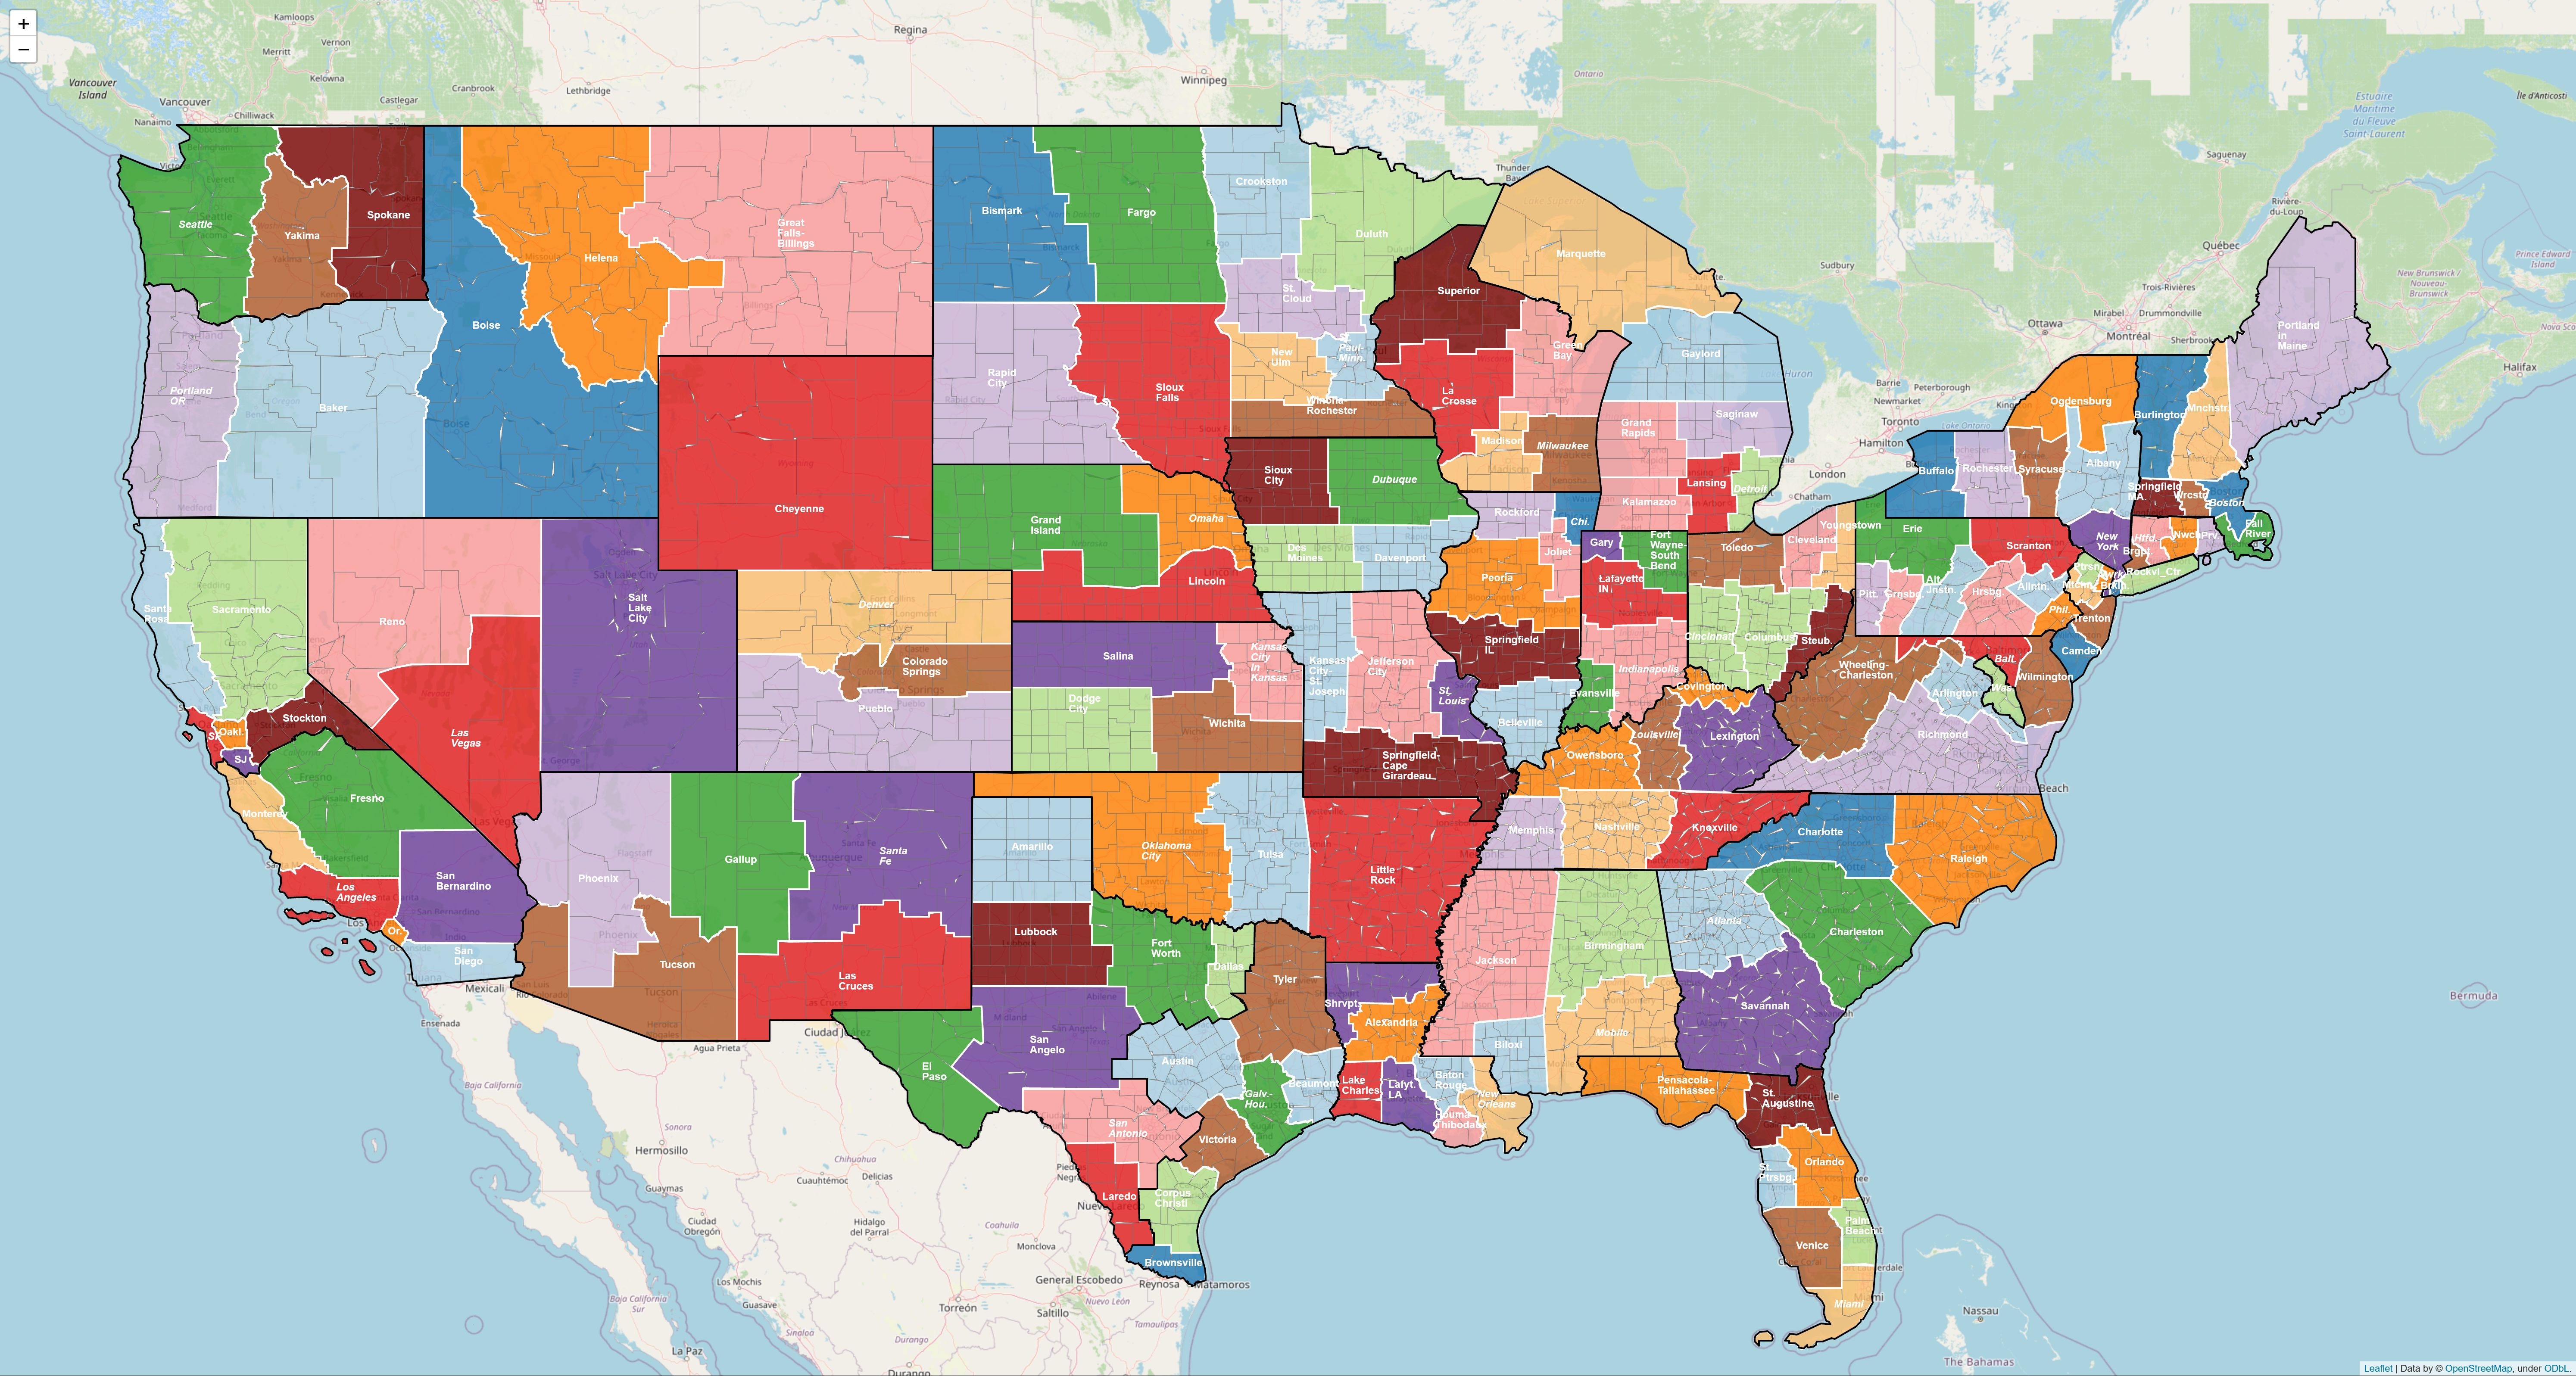

In [38]:
create_map_screenshot(
    absolute_path_to_map_folder = cwd, 
    map_name = 'diocese_map.html', screenshot_save_path = 'screenshots',
    webdriver_source='Firefox')

convert_png_to_smaller_jpg(png_folder = 'screenshots', 
png_image_name = 'diocese_map.png', jpg_folder = 'smaller_screenshots', 
quality_factor = 80)

IPython.display.Image(filename='smaller_screenshots/'+'diocese_map.jpg') 
# Based on https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html

This map is a good start, but it has a number of incorrect diocesan and provincial boundaries. (For instance, notice how the line between the dioceses of Grand Island and Lincoln is blocky rather than curved. The North Platte river serves as the main boundary between those dioceses, but this map uses county borders to demarcate diocese boundaries instead.)

Therefore, I'll now create maps that have revised boundaries and other improvements (such as cathedral locations).

# Generating a map with revised diocesan/provincial boundaries

In order to create my revised maps, I'll first import a revised set of diocesan and provincial boundaries. In order to revise the boundaries of a diocese or province, I first loaded it within geojson.io, a free online program that lets you edit geojson shapes. I then used diocese maps that I found on Wikipedia and webpages affiliated with dioceses to tweak the borders. The OpenStreetMap terrain view within geojson.io was very helpful in these efforts, since it contained county, reservation, town/city, and park borders, which form parts of the borders of certain dioceses.

Geojson.io does not support the editing of multipolygon shapes, so for provinces with multipolygon boundaries, I first needed to extract a single polygon from the multipolygon shape, then edit that part only within geojson.io. 

Once I had edited the shape, I copied and pasted it back within diocese_boundaries_revised.geojson (for dioceses) and province_boundaries_revised.geojson (for provinces).

Although these boundaries (like the simplified county shapefiles) are not exact, they are still a significant improvement over the original boundary shapefiles, which did not account for diocese and province boundaries that cut through counties. 

See the documentation_images folder of this project for a look at how I used geojson.io to revise diocese and province maps.

The following cell loads up my revised set of diocese boundaries, then merges in color codes and uses representative_point() to determine where to plot diocese names.

In [39]:
revised_diocese_boundaries = geopandas.read_file(
    'diocese_boundaries_revised.geojson')
revised_diocese_boundaries.sort_values('Diocese', inplace = True) 
revised_diocese_boundaries = revised_diocese_boundaries.merge(
    df_dioceses[['Diocese', 'Diocese_Color_Code']].drop_duplicates(), 
    on = 'Diocese')
revised_diocese_boundaries = revised_diocese_boundaries.merge(
    diocese_boundaries[['Diocese', 'name_for_plotting']], on = 'Diocese')
revised_diocese_boundaries
revised_diocese_boundaries['center'] = revised_diocese_boundaries[
    'geometry'].representative_point()
revised_diocese_boundaries.head(2)

STATEFP COUNTYFP  COUNTYNS  GEOID      NAME         NAMELSAD LSAD  \
0       36      091  00974143  36091  Saratoga  Saratoga County   06   
1       22      021  00558477  22021  Caldwell  Caldwell Parish   15   

   Unnamed: 0 State_Name State_Code  FIPS                county_state  \
0          31   New York         NY    36   Saratoga County, New York   
1          17  Louisiana         LA    22  Caldwell Parish, Louisiana   

      Province     Diocese                                           geometry  \
0     New York      Albany  POLYGON ((-74.78339 42.01512, -74.55360 42.121...   
1  New Orleans  Alexandria  POLYGON ((-93.29827 30.88300, -93.42428 30.883...   

   Diocese_Color_Code name_for_plotting                      center  
0                   0            Albany  POINT (-74.26500 42.82924)  
1                 102        Alexandria  POINT (-92.36865 31.67734)

In [40]:
revised_province_boundaries = geopandas.read_file('province_boundaries_revised.geojson')

In [41]:
revised_province_boundaries

Province  STATEFP COUNTYFP  COUNTYNS  GEOID  \
0           Anchorage-Juneau        2      130  01419973  02130   
1                    Atlanta       13      189  00348794  13189   
2                  Baltimore       51      775  01789074  51775   
3                     Boston       25      015  00606934  25015   
4                    Chicago       17      067  00424235  17067   
5                 Cincinnati       39      063  01074044  39063   
6                     Denver        8      109  00198170  08109   
7                    Detroit       26      109  01622997  26109   
8                    Dubuque       19      053  00465215  19053   
9          Galveston-Houston       48      057  01383814  48057   
10                  Hartford        9      007  00212797  09007   
11              Indianapolis       18      073  00450494  18073   
12     Kansas City in Kansas       20      073  00485003  20073   
13                 Las Vegas       49      033  01448030  49033   
14               Los Angeles        6      083  00277306  06083   
15                Louisville       21      053  00516873  21053   
16                     Miami       12      053  00295751  12053   
17                 Milwaukee       55      111  01581115  55111   
18                    Mobile        1      027  00161539  01027   
19               New Orleans       22      019  00558468  22019   
20                  New York       36      101  00974148  36101   
21                    Newark       34      037  00882236  34037   
22             Oklahoma City        5      137  00069902  05137   
23                     Omaha       31      039  00835841  31039   
24              Philadelphia       42      007  01214112  42007   
25        Portland in Oregon       41      063  01155135  41063   
26               San Antonio       48      327  01383949  48327   
27             San Francisco        6      091  00277310  06091   
28                  Santa Fe       35      011  00933054  35011   
29                   Seattle       53      069  01513275  53069   
30                 St. Louis       29      083  00758496  29083   
31  St. Paul and Minneapolis       46      099  01265772  46099   
32                Washington       78      030  02378250  78030   

                 NAME                   NAMELSAD LSAD  Unnamed: 0  \
0   Ketchikan Gateway  Ketchikan Gateway Borough   04         1.0   
1            McDuffie            McDuffie County   06         9.0   
2               Salem                 Salem city   25        45.0   
3           Hampshire           Hampshire County   06        20.0   
4             Hancock             Hancock County   06        12.0   
5             Hancock             Hancock County   06        34.0   
6            Saguache            Saguache County   06         5.0   
7           Menominee           Menominee County   06        21.0   
8             Decatur             Decatur County   06        14.0   
9             Calhoun             Calhoun County   06        42.0   
10          Middlesex           Middlesex County   06         NaN   
11             Jasper              Jasper County   06        13.0   
12          Greenwood           Greenwood County   06        15.0   
13               Rich                Rich County   06         NaN   
14      Santa Barbara       Santa Barbara County   06         4.0   
15            Clinton             Clinton County   06        16.0   
16           Hernando            Hernando County   06         8.0   
17               Sauk                Sauk County   06        48.0   
18               Clay                Clay County   06         0.0   
19          Calcasieu           Calcasieu Parish   15        17.0   
20            Steuben             Steuben County   06        31.0   
21             Sussex              Sussex County   06        29.0   
22              Stone               Stone County   06         3.0   
23             Cuming              Cuming County   06        26.0   
24             B

## Creating a cathedral list

In order to plot Latin-rite cathedrals on the map, I'll need to create a list of those cathedrals and their coordinates. I'll do so by first scraping Wikipedia's list of US Catholic Cathedrals, then merging the DataFrame version of that list with df_provinces. 

Note: I commented out the following code after running it, as (1) it had already served its purpose of obtaining an initial list of cathedrals, and (2) it didn't run correctly later on, potentially due to a change in the original Wikipedia page.

In [42]:
# cathedral_list = pd.read_html(
#     'https://en.wikipedia.org/wiki/List_of_Catholic_cathedrals_in_the_United_States')[
#         0][['Diocese', 'Cathedral']]
# cathedral_list['Diocese'] = cathedral_list['Diocese'].str.replace(
#     'Diocese of', '').str.replace('Archdiocese of', '').str.strip()
# # Adding str.strip() ended up being necessary for the merge to work
# cathedral_list['Cathedral_List'] = [
#     [cathedral_list['Cathedral'][i]] for i in range(len(cathedral_list))]
# cathedral_list.drop('Cathedral', axis = 1, inplace = True)
# cathedral_list['Cathedral_coord_list'] = [
#     [] for i in range(len(cathedral_list))]
# df_provinces_cathedrals = df_provinces.merge(
#     cathedral_list, on = 'Diocese', how = 'left')
# df_provinces_cathedrals.to_csv('diocese_province_cathedral_list.csv', 
# index = False)
# df_provinces_cathedrals

I then revised this list within a spreadsheet editor. To obtain the geographic locations of each cathedral, I used multiple tools, including OpenStreetMap, Wikipedia, and GeoHack (which I believe uses the GPL license: https://bitbucket.org/magnusmanske/geohack/src/master/LICENSE). GeoHack proved to be the fastest method for accessing coordinates, in part because not all cathedrals were listed on OpenStreetMap. I accessed each cathedral's GeoHack page by clicking on the coordinates listed on that cathedral's Wikipedia page. (I used GeoHack instead of the coordinates shown on Wikipedia because the former offered coordinates in decimal degree format.)

I also saved the cathedral names within lists using double quotes so that they could be interpreted by json.loads().

In [43]:
df_cathedral_locations = pd.read_csv(
    'diocese_province_cathedral_list_revised.csv')

df_cathedral_locations

Diocese                  Province  \
0            Anchorage-Juneau          Anchorage-Juneau   
1                   Fairbanks          Anchorage-Juneau   
2                     Atlanta                   Atlanta   
3                  Charleston                   Atlanta   
4                   Charlotte                   Atlanta   
..                        ...                       ...   
171                 St. Cloud  St. Paul and Minneapolis   
172  St. Paul and Minneapolis  St. Paul and Minneapolis   
173          Winona-Rochester  St. Paul and Minneapolis   
174                St. Thomas                Washington   
175                Washington                Washington   

                                        Cathedral_List  \
0    ["Our Lady of Guadalupe Cathedral (Anchorage)"...   
1                    ["Cathedral of the Sacred Heart"]   
2                     ["Cathedral of Christ the King"]   
3              ["Cathedral of Saint John the Baptist"]   
4                       ["Cathedral of Saint Patrick"]   
..                                                 ...   
171                        ["Cathedral of Saint Mary"]   
172  ["Cathedral of Saint Paul (Saint Paul)", "Basi...   
173  ["Cathedral of the Sacred Heart (Winona)", "Co...   
174                ["Saints Peter and Paul Cathedral"]   
175         ["Cathedral of Saint Matthew the Apostle"]   

                                  Cathedral_coord_list  \
0    [[61.18492777777778, -149.94404444444444], [58...   
1                             [[64.83631, -147.78065]]   
2                               [[33.8279, -84.38699]]   
3                              [[32.77656, -79.93447]]   
4                              [[35.20529, -80.84475]]   
..                                                 ...   
171                              [[45.5588, -94.1614]]   
172  [[44.946944, -93.108889], [44.973056, -93.2863...   
173          [[44.0484, -91.6395], [44.023, -92.4685]]   
174                          [[18.341011, -64.936792]]   
175                              [[38.906111, -77.04]]   

                                                 Notes  
0    Our Lady of Guadalupe Cathedral's coordinates ...  
1                                                  NaN  
2                                                  NaN  
3                                                  NaN  
4                                                  NaN  
..                                                 ...  
171                               Obtained via GeoHack  
172                               Obtained via GeoHack  
173                               Obtained via GeoHack  
174                               Obtained via GeoHack  
175                               Obtained via GeoHack  

[176 rows x 5 columns]

## Adding in water features

The map created earlier looks rather strange in areas that contain bodies of water. (Notice how the Great Lakes are missing from the map, for instance.) This is because the county shapefiles that I retrieved from the US Census Bureau extend past shorelines.

To add the lakes and other major water features back in, I'll download water boundaries from the US Census Bureau, filter them to include only major features, simplify them, and save them to a .geojson file. This will make it easier to plot them.

In [44]:
generate_water_features = False
water_simplification_level = simplification_level # Setting these
# two equal to each other for now, but consider decreasing
# water_simplification_level in order to produce smaller map file sizes.

In [45]:
if generate_water_features == True:
    us_water_bodies = geopandas.read_file(r'C:\Users\kburc\Downloads\tlgdb_2021_a_us_areawater.gdb\tlgdb_2021_a_us_areawater.gdb')
    # File source: 
    # https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-geodatabase-file.2021.html
    # (Click on "Areal Hydrography National Geodatabase" to download the 
    # .zip file). Even though 'tlgdb_2021_a_us_areawater.gdb' is actually 
    # a folder, GeoPandas is still able to read it into a GeoDataFrame.
    print(pd.value_counts(us_water_bodies['MTFCC']))
    # Shows the different MTFCC codes present in the dataset, 
    # along with the number of features present for each code:
    mtfcc_code_list = ['H2030', 'H2040', 'H2051', 'H2053']
    # These are the codes for lakes/ponds, reservoirs, 
    # bays/estuaries/gulfs/sounds, and oceans/seas. 
    major_us_water_bodies = us_water_bodies.query(
        "MTFCC in @mtfcc_code_list").query("AWATER > 10000000").copy()
    major_us_water_bodies
    major_us_water_bodies['geometry'] = major_us_water_bodies[
        'geometry'].simplify(tolerance = water_simplification_level)
    # For some reason, major_us_water_bodies doesn't include the part
    # of Lake Erie north of Youngstown. Therefore, I added this part
    # in manually by selecting it using the .cx method within 
    # GeoPandas, then adding it to major_us_water_bodies.
    boundary = [41.7050, -81.1780, 42.7231, -80.4419]
    water_north_of_youngstown = us_water_bodies.cx[-81.1780:-80.4419, 
    41.7050:42.7231].copy()
    # See https://geopandas.org/en/stable/docs/user_guide/indexing.html
    # water_north_of_youngstown = water_north_of_youngstown.query(
    #     "MTFCC in @mtfcc_code_list")
    water_north_of_youngstown['geometry'] = water_north_of_youngstown[
        'geometry'].simplify(tolerance = water_simplification_level)
    major_us_water_bodies = pd.concat([major_us_water_bodies, 
    water_north_of_youngstown]).drop_duplicates().copy()

    print(pd.value_counts(major_us_water_bodies['MTFCC']))
    major_us_water_bodies.to_file('major_us_water_bodies.geojson')
    # Note: This file is 6.79 MB in size (at least on my computer)
    # when water_simplification_level is set to 0.005. When I
    # increased the tolerance to 0.1, the file size decreased to
    # around 4.3 MB, but the water boundaries
    # became noticeably jagged.

else:
    major_us_water_bodies = geopandas.read_file('major_us_water_bodies.geojson')


C:\Users\kburc\AppData\Local\Temp\ipykernel_12196\3073223851.py:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(us_water_bodies['MTFCC']))


MTFCC
H2030    2182304
H3010      53349
H2040       9403
H2051       8642
H3020       2561
H2081       1610
H2053        627
H2041        241
H3013         53
Name: count, dtype: int64


C:\Users\kburc\AppData\Local\Temp\ipykernel_12196\3073223851.py:34: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(major_us_water_bodies['MTFCC']))


MTFCC
H2030    1702
H2051    1548
H2053     320
H2040     228
H3010      15
Name: count, dtype: int64


The following function creates an .HTML map of dioceses, provinces, and cathedral locations. It is similar to the mapping code shown earlier but has a number of improvements.

In [46]:
def create_diocese_map(tile_option = 'OpenStreetMap', starting_zoom = 6, 
starting_location = [38.7, -95], save_path = 'revised_diocese_map', 
include_cathedrals = True, include_names = True, include_counties = True,
include_water_bodies = True):
    ''' include_cathedrals, include_names, and include_counties determine
    whether the final map will show cathedrals, diocese names, and
    county outlines and names, respectively. I uploaded
    screenshots of a name-free and cathedral-free map to Wikimedia Commons
    for use in Wikipedia pages. Excluding counties allows the final map size
    to be significantly smaller, thus allowing it to get uploaded
    to Google Sites (which currently has a 15MB limit in place for pages
    built on embedded HTML).
    '''    
    revised_diocese_map = folium.Map(location=starting_location, 
    zoom_start=starting_zoom, tiles = tile_option)
    # tiles can be set to 'None' in order to produce a map without any 
    # background details. This produces a cleaner static image.

    # Although Folium has a choropleth library, I wasn't able to find a way
    # to disable the default legend. Therefore, I am instead using a custom
    # choropleth mapping function. Much of this function is based on 
    # Amodiovalerio Verde's code at:
    # https://vverde.github.io/blob/interactivechoropleth.html . 

    colormap = branca.colormap.linear.Paired_12.to_step(
        12, data = revised_diocese_boundaries['Diocese_Color_Code'])
    colormap
    # As noted earlier, this colormap will be used to assign different
    # map colors to different dioceses.

    # Adding in county borders:

    if include_counties == True:
        print("Adding in counties:")

        county_style_function = lambda x: {
                "weight": 0.5,
                'color': '#000000',
                'fillOpacity': 0}
        # See https://python-visualization.github.io/folium/modules.html#folium.vector_layers.path_options
        # for a list of items that can be included within a style function.
        # The above parameters will plot county shapes as thin black lines without
        # any fill color.

        folium.features.GeoJson(df_dioceses, name = 'Counties',
        style_function=county_style_function).add_to(revised_diocese_map)
        # See https://python-visualization.github.io/folium/modules.html#folium.features.GeoJson
        # for more information on adding GeoJson elements to Folium maps.

    # Adding in bodies of water:
    if include_water_bodies == True:
        print("Adding in bodies of water:")

        water_style_function = lambda x: {
                    "weight": 0.5,
                    'color': '#0000FF',
                    'fillOpacity': 1}
                # This style function will plot the bodies of water in
                # major_us_water_bodies as opaque blue polygons.

        folium.features.GeoJson(major_us_water_bodies, name = 'Bodies of Water',
            style_function=water_style_function).add_to(revised_diocese_map)

    # Adding in diocese colors and borders:
    print("Adding in dioceses:")

    diocese_style_function = lambda x: {
            "fillOpacity": 0.8,
            "weight": 2,
            'color': '#FFFFFF',
            "fillColor": '#770000' if
            colormap(x['properties']['Diocese_Color_Code']) == '#ffff99ff'
            else colormap(x['properties']['Diocese_Color_Code'])}
            # Note that 'properties' has to be added before the column name.
            # This can be inferred from the GeoJson definition within Folium:
            # https://python-visualization.github.io/folium/modules.html#folium.features.GeoJson}
    # This style function adds diocese colors and 
    # thick white diocesan boundaries to the map.
    # Note that colormap is used to determine the color of each diocese. 
    # (#ffff99ff, the yellow color within the colormap, makes it harder to read
    # white diocese names, so the style function changes this color to a dark
    # red whenever it appears.

    folium.features.GeoJson(revised_diocese_boundaries[
        ['geometry', 'Diocese_Color_Code']], 
    name = 'Dioceses', style_function=diocese_style_function).add_to(
        revised_diocese_map)
    # revised_diocese_boundaries includes both geometry and point values. 
    # The point values confuse the interpreter, so in order to avoid
    # an error message, I entered 'geometry' here so that only 
    # those coordinate values would be used.

    # Adding in province borders:
    print("Adding in provinces:")
    province_style_function = lambda x: {
            'weight': '2', 
            'fillOpacity': 0,
            'color': 
            '#000000', 
            'Fill': False} 

    folium.GeoJson(revised_province_boundaries, name = "Provinces", 
    style_function = province_style_function).add_to(revised_diocese_map)


    # Adding in tooltips:
    # The following lines of code add in 'tooltips,' which are text values
    # that appear when the user hovers over a given county. These tooltips
    # will reveal county, diocese, and province information. They are added
    # after the counties, dioceses, and provinces so that those features won't
    # # block the tooltips from view. 
    print("Adding in tooltips:")
    if include_counties == True:
        tooltip = folium.features.GeoJsonTooltip(fields = 
        ['county_state', 'Diocese_Detail', 'Province_Detail'], aliases = 
        ['County', 'Diocese', 'Province'])
        # Based on https://python-visualization.github.io/folium/modules.html#folium.features.GeoJsonTooltip
    else: # This verison of the tooltip won't include county names.
        tooltip = folium.features.GeoJsonTooltip(fields = 
        ['Diocese_Detail', 'Province_Detail'], aliases = 
        ['Diocese', 'Province'])

    tooltip_style_function = lambda x: {
            "fillOpacity": 0,
            "weight": 0,
            'color': '#000000',
            'Fill': False}
            # This style function makes the other components of the tooltips
            # invisible so as not to alter the appearance of the map.

    folium.features.GeoJson(df_dioceses, tooltip = tooltip, name = 'Tooltips',
    style_function=tooltip_style_function).add_to(revised_diocese_map)


    # Adding in cathedrals:
    # This section of the code adds in cathedral markers. Diocesan and 
    # archdiocesan cathedrals are given separate markers.
    if include_cathedrals == True:
        print("Adding in cathedrals:")
        # First, I'll add in variables that govern the size of the icons that
        # I'll plot:
        icon_width = 10
        icon_height = icon_width/(120/200)
        # The original markers are 120 by 200 pixels, so dividing the icon's 
        # width by this same ratio preserves the original shape of the icons
        # during the plotting process.
        cathedral_counter = 0
        cathedral_feature_group = folium.FeatureGroup(name = 'Cathedrals')
        # cathedral_feature_group will store all of the cathedral markers
        # on the map. The benefit of this setup is that cathedrals can then 
        # be toggled on and off using Folium's LayerControl feature.
        # This method comes from Bob Haffner at
        # https://stackoverflow.com/a/61283334/13097194 .
        # See also: https://python-visualization.github.io/folium/modules.html#folium.map.FeatureGroup

        for i in range(len(df_cathedral_locations)):
            # print(i)
            # First, I'll retrieve the locations of each cathedral from
            # df_cathedral_locations. Since I saved the locations in 
            # JSON format, I can use json.loads to convert those locations
            # into a list of lists that Python can interpret.
            # If you need to double-check how to convert an item
            # (such as a list of lists) into JSON format, you can pass that
            # item to json.dumps(). 
            loc_list = json.loads(df_cathedral_locations.iloc[
                i, df_cathedral_locations.columns.get_loc(
                    'Cathedral_coord_list')])
            # Each row of the DataFrame has a list of cathedral locations, 
            # as a given diocese can have more than one cathedral. Dioceses
            # with only one cathedral have a list with only one entry.
            # I'll also use json.loads() to extract a list of cathedral 
            # names from each row.
            cathedral_list = json.loads(df_cathedral_locations.iloc[
                i, df_cathedral_locations.columns.get_loc('Cathedral_List')])

            diocese_name = df_cathedral_locations.iloc[
                i, df_cathedral_locations.columns.get_loc('Diocese')]
            if diocese_name == df_cathedral_locations.iloc[
                i, df_cathedral_locations.columns.get_loc('Province')]:
                # print("True")
                marker = 'globus_cruciger_archbishop.png'
            # For archdioceses, I use a double-barred globus cruciger (see
            # https://en.wikipedia.org/wiki/Globus_cruciger ). For 
            # dioceses, I use a single-barred globus cruciger. I created these
            # images within Inkscape and release them into the public domain.
            else:
                marker = 'globus_cruciger.png'
            for j in range(len(loc_list)):
                folium.Marker(loc_list[j], icon = folium.CustomIcon(
                    marker, icon_size = (icon_width, icon_height)), 
                    tooltip = cathedral_list[j]).add_to(cathedral_feature_group)
                # See https://python-visualization.github.io/folium/modules.html#folium.features.CustomIcon
                # and https://python-visualization.github.io/folium/modules.html
                cathedral_counter += 1
        print("Added",cathedral_counter,"cathedrals to the map.")
        # Each cathedral then gets added to the feature group so that
        # all cathedrals can be toggled on or off at once.
        cathedral_feature_group.add_to(revised_diocese_map)


    # Adding in diocese names:
    if include_names == True:
        print("Adding in diocese names:")
        name_feature_group = folium.FeatureGroup(name = 'Diocese Names')
        # I'll first retrieve the coordinate at which to plot the name:
        for i in range(len(revised_diocese_boundaries)):
            center_point = [float(revised_diocese_boundaries.iloc[
                i, revised_diocese_boundaries.columns.get_loc('center')].y),
            float(revised_diocese_boundaries.iloc[
                i, revised_diocese_boundaries.columns.get_loc('center')].x)] 
            # The use of .y and .x here is based on Francois M.'s response at:
            # https://gis.stackexchange.com/a/255867/195615
            diocese_name = revised_diocese_boundaries.iloc[
                i, revised_diocese_boundaries.columns.get_loc('Diocese')]
            diocese_name_for_plotting = revised_diocese_boundaries.iloc[
                i, revised_diocese_boundaries.columns.get_loc(
                    'name_for_plotting')]
            # Folium will plot each word (whether separated by a space or a 
            # hyphen) on a separate line. Therefore, in order to place each
            # diocese name close to its corresponding center_point location,
            # I created horizontal_offset and vertical_offset values that 
            # could be passed to the icon_anchor parameter or 
            # folium.DivIcon (see below).
            split_name = diocese_name_for_plotting.replace('-', ' ').split(' ')
            # split_name determines on how many lines a given diocese name
            # will appear. By replacing all hyphens with spaces, I can split
            # on all parts of the string that originally contained a hyphen
            # or a space. This clever trick comes from Louis LC at
            # https://stackoverflow.com/a/7215696/13097194 .

            # I want to shift the text back so that it remains centered.
            # To do so, I'll find the longest word within split_name and then
            # set the horizontal offset based on 3 * that word's length. (I 
            # determined this number via trial and error.)
            horizontal_offset = max([len(word) for word in split_name])*3

            # Similarly, in order to keep the text vertically centered, 
            # I'll create a vertical offset value based on the total number
            # of lines within split_name.
            vertical_offset = len(split_name)*10

            # This style tag will allow me to control some basic style
            # properties of each diocese's name.
            style_tag = '<style> p{color:white; line-height: 1} </style>'
            # Based on https://developer.mozilla.org/en-US/docs/Web/HTML/Element/style
        
            if diocese_name == revised_diocese_boundaries.iloc[
                i, revised_diocese_boundaries.columns.get_loc(
                    'Province')]: # E.g. if this is an archdiocese 
            # (as provinces are named after archdioceses)
            # The following line plots archdioceses' names in bold and 
            # italic font using HTML tags.
            # The strategy of using an invisible folium.Marker object to display text on 
            # the map via DivIcon elements comes from from Bob Haffner's response at:
            # https://stackoverflow.com/a/56878525/13097194 or:
            # and https://stackoverflow.com/a/46408144/13097194
            # See https://python-visualization.github.io/folium/modules.html#folium.features.DivIcon
            # for more information on the use of DivIcon.
                folium.Marker(center_point, icon = folium.DivIcon(
                icon_anchor=(horizontal_offset, vertical_offset), 
            html=f"{style_tag}<p><b><i>{diocese_name_for_plotting}</i><b></p>")
            ).add_to(name_feature_group)
            else:
                # Dioceses' names are still in bold but are not italicized.
                folium.Marker(center_point, icon = folium.DivIcon(
                icon_anchor=(horizontal_offset, vertical_offset), 
                html=f"{style_tag}<p><b>{diocese_name_for_plotting}</b></p>")
                ).add_to(name_feature_group)
    
            # folium.CircleMarker(center_point, radius = 1).add_to(revised_diocese_map) 
            # The above line is very useful for debugging what offsets to use
            # when placing text on the map.
        # Finally, each diocese name gets added to name_feature_group.
        name_feature_group.add_to(revised_diocese_map)

    folium.LatLngPopup().add_to(revised_diocese_map) 
    # Useful for editing diocese boundaries

    folium.LayerControl().add_to(revised_diocese_map) # This allows the user
    # to select which layers of the map (provinces, cathedrals, diocese names,
    # etc. to display.)
    print("Saving map:")
    revised_diocese_map.save(save_path+'.html')

    # colormap.add_to(m) # This functions as the map's legend, but since the
    # colors have no real meaning, it will be excluded from this map.

    return revised_diocese_map

I'll now create a revised diocese map using the function defined above:

In [61]:
create_diocese_map()
print('Finished creating map.')

Note that this map features the revised diocese and province lines. (For instance, the boundary between the dioceses of Lincoln and Grand Island is now 'wavy' instead of straight, as it now follows the course of the Platte River.) 
I'll now create .png and .jpg screenshots of this map. (Note that all screenshots can be found in the screenshots and smaller_screenshots folders of this project.)

In [48]:
create_map_screenshot(
    absolute_path_to_map_folder = 
    cwd, 
    map_name = 'revised_diocese_map.html', screenshot_save_path = 'screenshots')
convert_png_to_smaller_jpg(png_folder = 'screenshots', 
png_image_name = 'revised_diocese_map.png', jpg_folder = 'smaller_screenshots', 
quality_factor = 80)

The above map shows OpenStreetMap tiles and data in the background. This is helpful for the interactive .HTML map, but I prefer the look of map screenshots that don't have this extra data. Therefore, I'll create a 'tileless' version of the revised diocese map:

In [49]:
create_diocese_map(tile_option = None, save_path = 'revised_diocese_map_tileless')

create_map_screenshot(
    absolute_path_to_map_folder = 
    cwd, 
    map_name = 'revised_diocese_map_tileless.html', 
    screenshot_save_path = 'screenshots')
convert_png_to_smaller_jpg(png_folder = 'screenshots', 
png_image_name = 'revised_diocese_map_tileless.png', 
jpg_folder = 'smaller_screenshots', 
quality_factor = 80)

Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in cathedrals:
Added 194 cathedrals to the map.
Adding in diocese names:
Saving map:


The screenshots of these maps have an important limitation: they don't include Alaska or Hawaii. Therefore, I created a function below that generates map screenshots that also contain these two states. 

In [50]:
def add_alaska_and_hawaii(starting_map_name, tile_option = 'OpenStreetMap', 
include_cathedrals = True, include_names = True):
    '''This function creates a static version of the map stored at
    starting_map_name.html that includes Alaska and Hawaii at the bottom left.
    The value of starting_map_name should not include the .html at the end. 
    E.g. pass revised_diocese_map as an argument rather than 
    revised_diocese_map.html.
    This function assumes that starting_map_name.html was produced using 
    generate_diocese_map() with a starting zoom of 6 and a starting location
    of [38.7, -95] (the default parameters for generate_diocese_map().) It also
    assumes that a .png screenshot of that map was already created using
    create_map_screenshot().

    This function performs the following tasks:
    1. Creates .HTML maps of Alaska and Hawaii. (These are the same as the maps 
    created above except that they are centered near Alaska and Hawaii).
    2. Saves these maps as screenshots, then creates cropped versions
    of the screenshots that focus  on each state.
    3. Loads the screenshot of a map specified by 'starting_map_name'; 
    pastes the cropped Alaska and Hawaii images in at the bottom left corner;
    and saves this new screenshot.  

    Note that the names of the additional maps and screenshots 
    created within this function are based off starting_map_name.
    ''' 

    # Part 1: Creating Alaska map, screenshot, and cropped screenshot
    create_diocese_map(tile_option = tile_option, starting_zoom = 4, 
    starting_location = [65, -150], save_path = starting_map_name+'_alaska', 
    include_cathedrals = include_cathedrals, include_names = include_names)
    # This method of creating an Alaska-centric map is admittedly very
    # inefficient, as it also generates all other parts of the map.
    # Another option would be to use Selenium to navigate to Alaska and then
    # take the screenshot from there, but I had trouble finding a way to
    # get that to work. Therefore, I'll create extra .HTML maps instead.
    # You may choose to delete these extra .HTML maps, since they are only
    # used for screenshot generation.
    create_map_screenshot(absolute_path_to_map_folder = 
        cwd, 
        map_name = starting_map_name+'_alaska.html', 
        screenshot_save_path = 'screenshots')
    os.remove(starting_map_name+'_alaska.html') # This .HTML 
    # file is no longer needed, so it can be removed to save
    # file space.
    # https://docs.python.org/3/library/os.html
    with PIL.Image.open(
        'screenshots/'+starting_map_name+'_alaska.png') as map_image:
        # See https://pillow.readthedocs.io/en/stable/reference/Image.html
        print("Opened")
        cropped_image = map_image.crop((2200, 1100, 3500, 2300)) # Crops the
        # map based on the specified left, upper, right, and lower points. See
        # https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.crop
        # As with other parts of this program, these points were determined
        # using trial and error.
        # display(cropped_image) # https://stackoverflow.com/a/26649884/13097194
        # Useful for debugging
        cropped_image.save(
            'screenshots/'+starting_map_name+'_alaska_cropped.png')

    # Part 2: Creating Hawaii map, screenshot, and cropped screenshot
    create_diocese_map(tile_option = tile_option, starting_zoom = 6, 
    starting_location = [21, -156], save_path = starting_map_name+'_hawaii', 
    include_cathedrals = include_cathedrals, include_names = include_names)
    create_map_screenshot(absolute_path_to_map_folder = 
        cwd, 
        map_name = starting_map_name+'_hawaii.html', 
        screenshot_save_path = 'screenshots')
    os.remove(starting_map_name+'_hawaii.html')
    with PIL.Image.open(
        'screenshots/'+starting_map_name+'_hawaii.png') as map_image:
        print("Opened")
        cropped_image = map_image.crop((2500, 1400, 3300, 1900)) 
        cropped_image.save(
            'screenshots/'+starting_map_name+'_hawaii_cropped.png')
    
    # Part 3: Pasting these screenshots into the original map 
    with PIL.Image.open('screenshots/'+starting_map_name+'.png') as map_image:
        alaska = PIL.Image.open(
            'screenshots/'+starting_map_name+'_alaska_cropped.png')
        alaska = alaska.resize(
            (int(alaska.width/1.25), int(alaska.height/1.25)))
        hawaii = PIL.Image.open(
            'screenshots/'+starting_map_name+'_hawaii_cropped.png')
        # The following lines paste the cropped Alaska and Hawaii maps
        # onto starting_map_name.png.
        map_image.paste(im = alaska, box = (0, 2300))
        map_image.paste(im = hawaii, box = (1200, 2600))
        map_image.save('screenshots/'+starting_map_name+'_50_states.png')



Here's what the output of add_alaska_and_hawaii look like when applied to the tileless map:

Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in cathedrals:
Added 194 cathedrals to the map.
Adding in diocese names:
Saving map:
Opened
Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in cathedrals:
Added 194 cathedrals to the map.
Adding in diocese names:
Saving map:
Opened


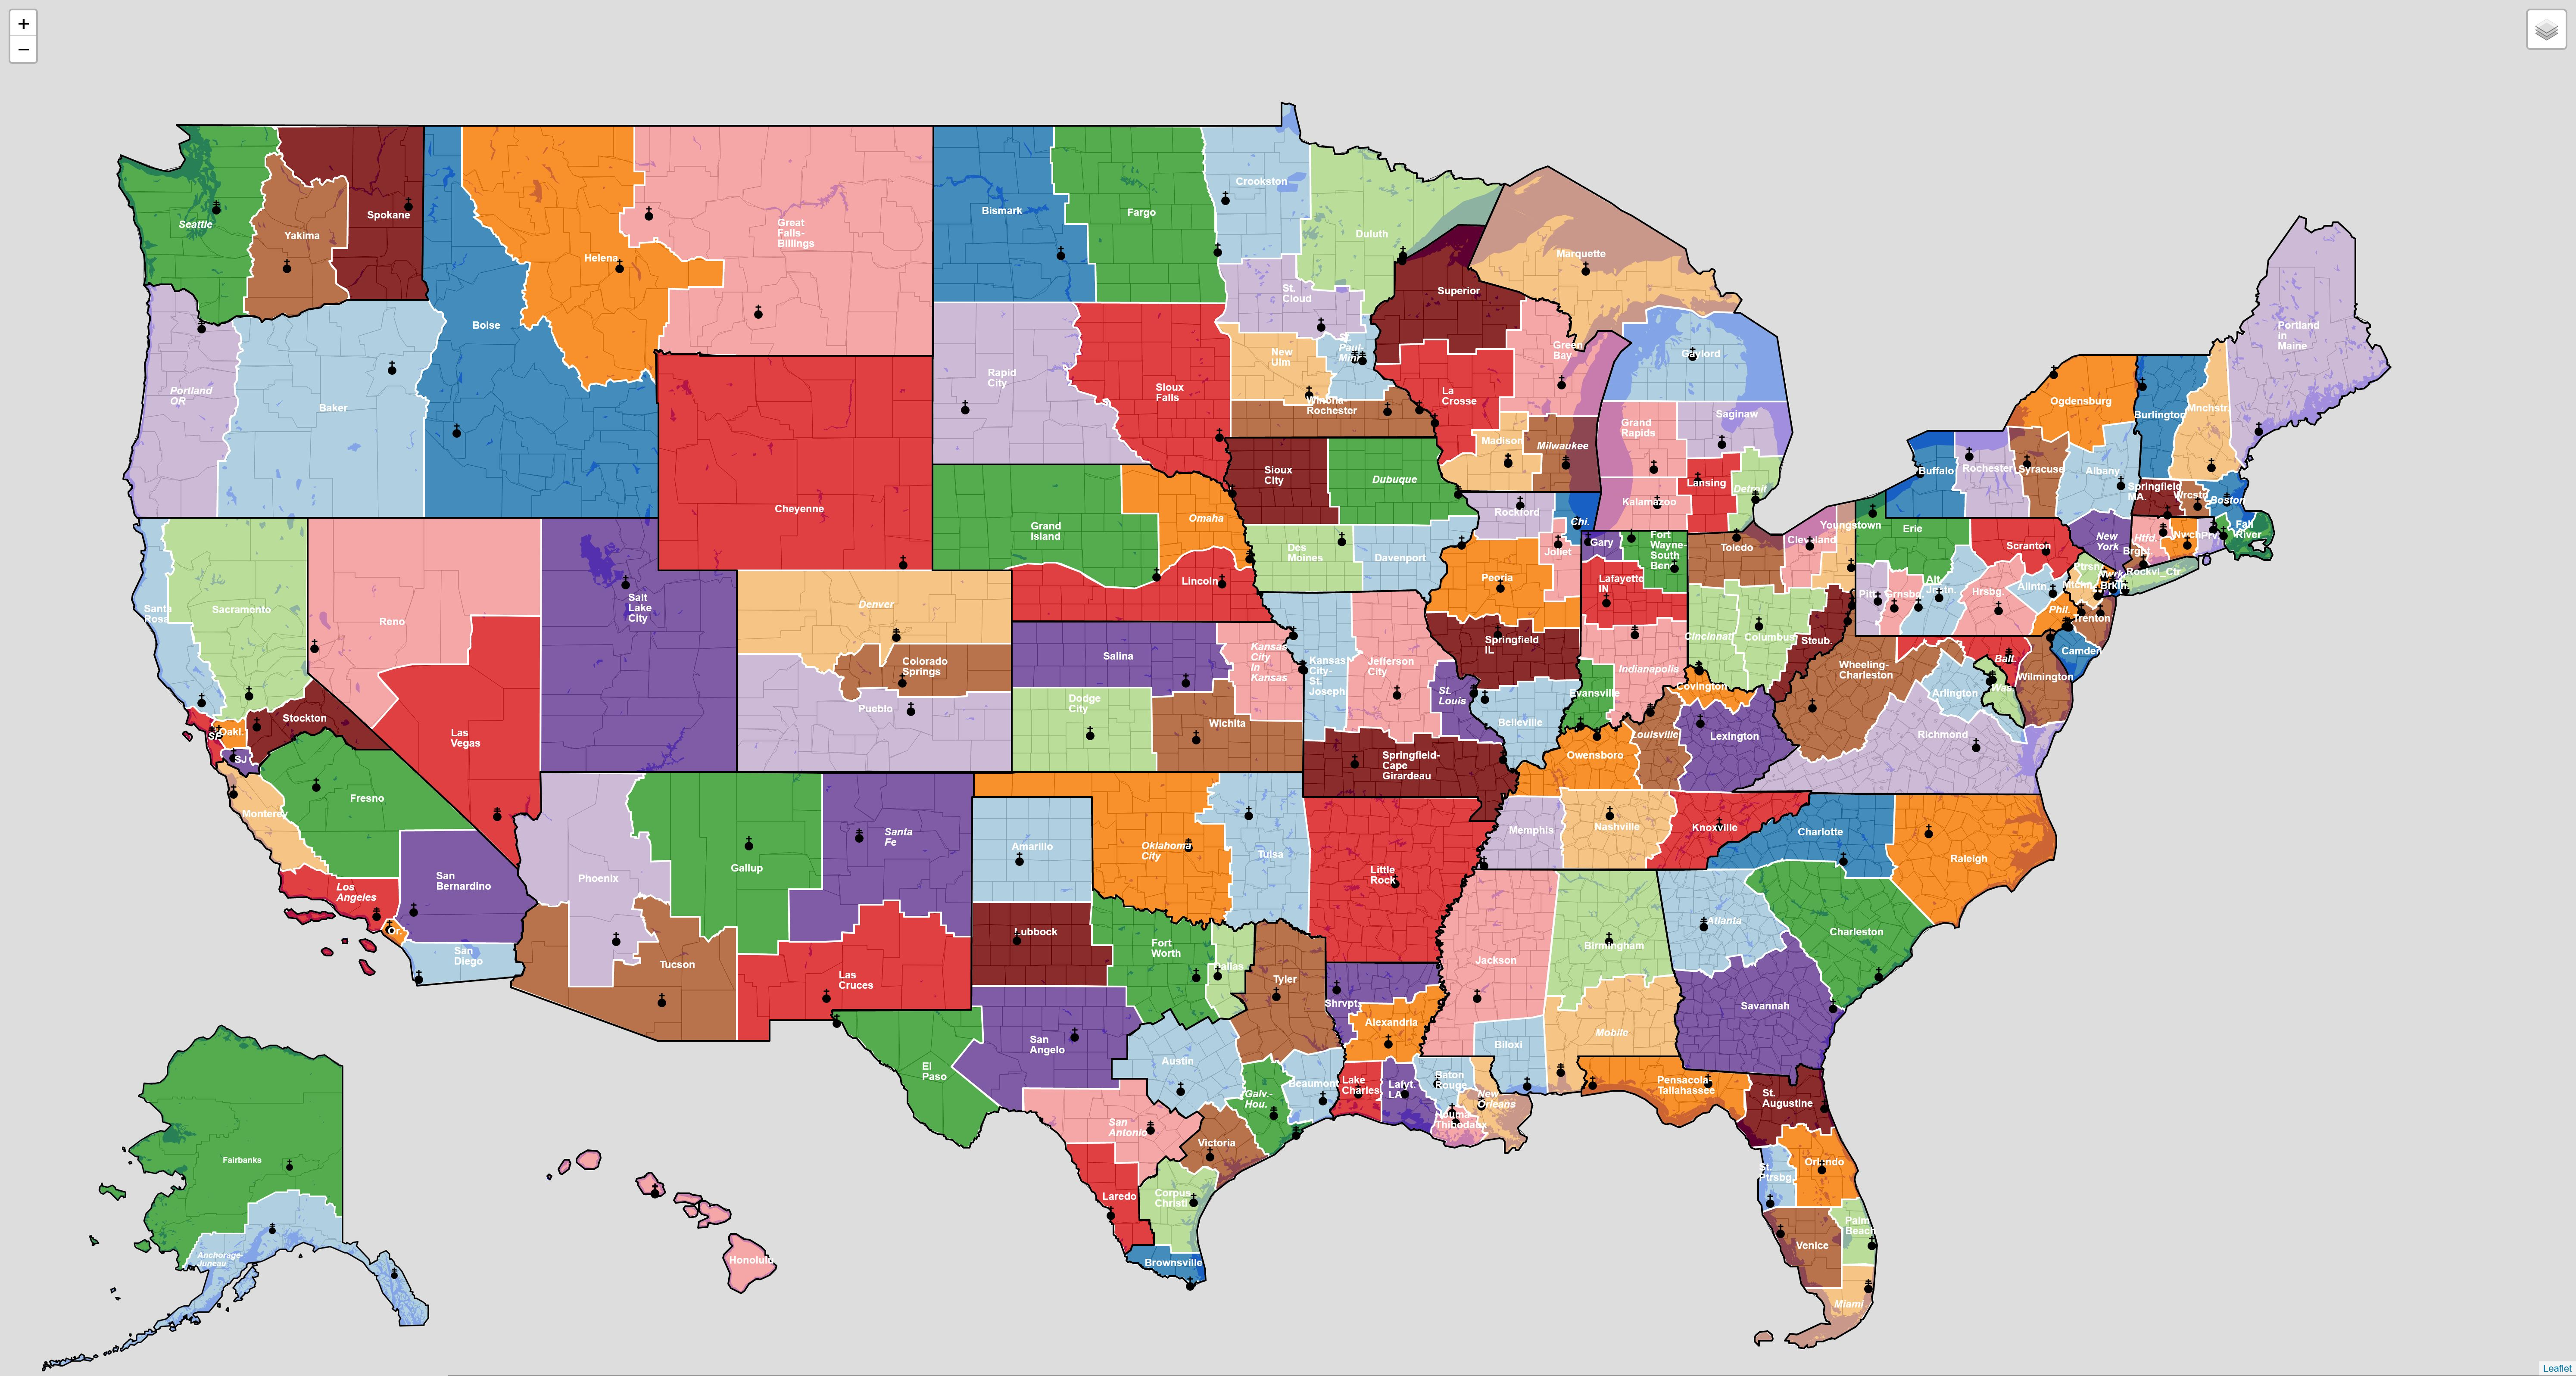

In [51]:
convert_png_to_smaller_jpg(png_folder = 'screenshots', 
png_image_name = 'revised_diocese_map_tileless.png', 
jpg_folder = 'smaller_screenshots', 
quality_factor = 80)

IPython.display.Image(filename='smaller_screenshots/'+'revised_diocese_map_tileless.jpg') 
# Based on https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html

add_alaska_and_hawaii(tile_option = None, 
starting_map_name = 'revised_diocese_map_tileless')

convert_png_to_smaller_jpg(png_folder = 'screenshots', 
png_image_name = 'revised_diocese_map_tileless_50_states.png', 
jpg_folder = 'smaller_screenshots', 
quality_factor = 80)

IPython.display.Image(
    filename='smaller_screenshots/'+'revised_diocese_map_tileless_50_states.jpg') 
# Based on https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html

I'll also create a 50-state map that includes OpenStreetMap tiles. However, this one will look more cluttered than the tileless version.

In [52]:
add_alaska_and_hawaii('revised_diocese_map')

Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in cathedrals:
Added 194 cathedrals to the map.
Adding in diocese names:
Saving map:
Opened
Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in cathedrals:
Added 194 cathedrals to the map.
Adding in diocese names:
Saving map:
Opened


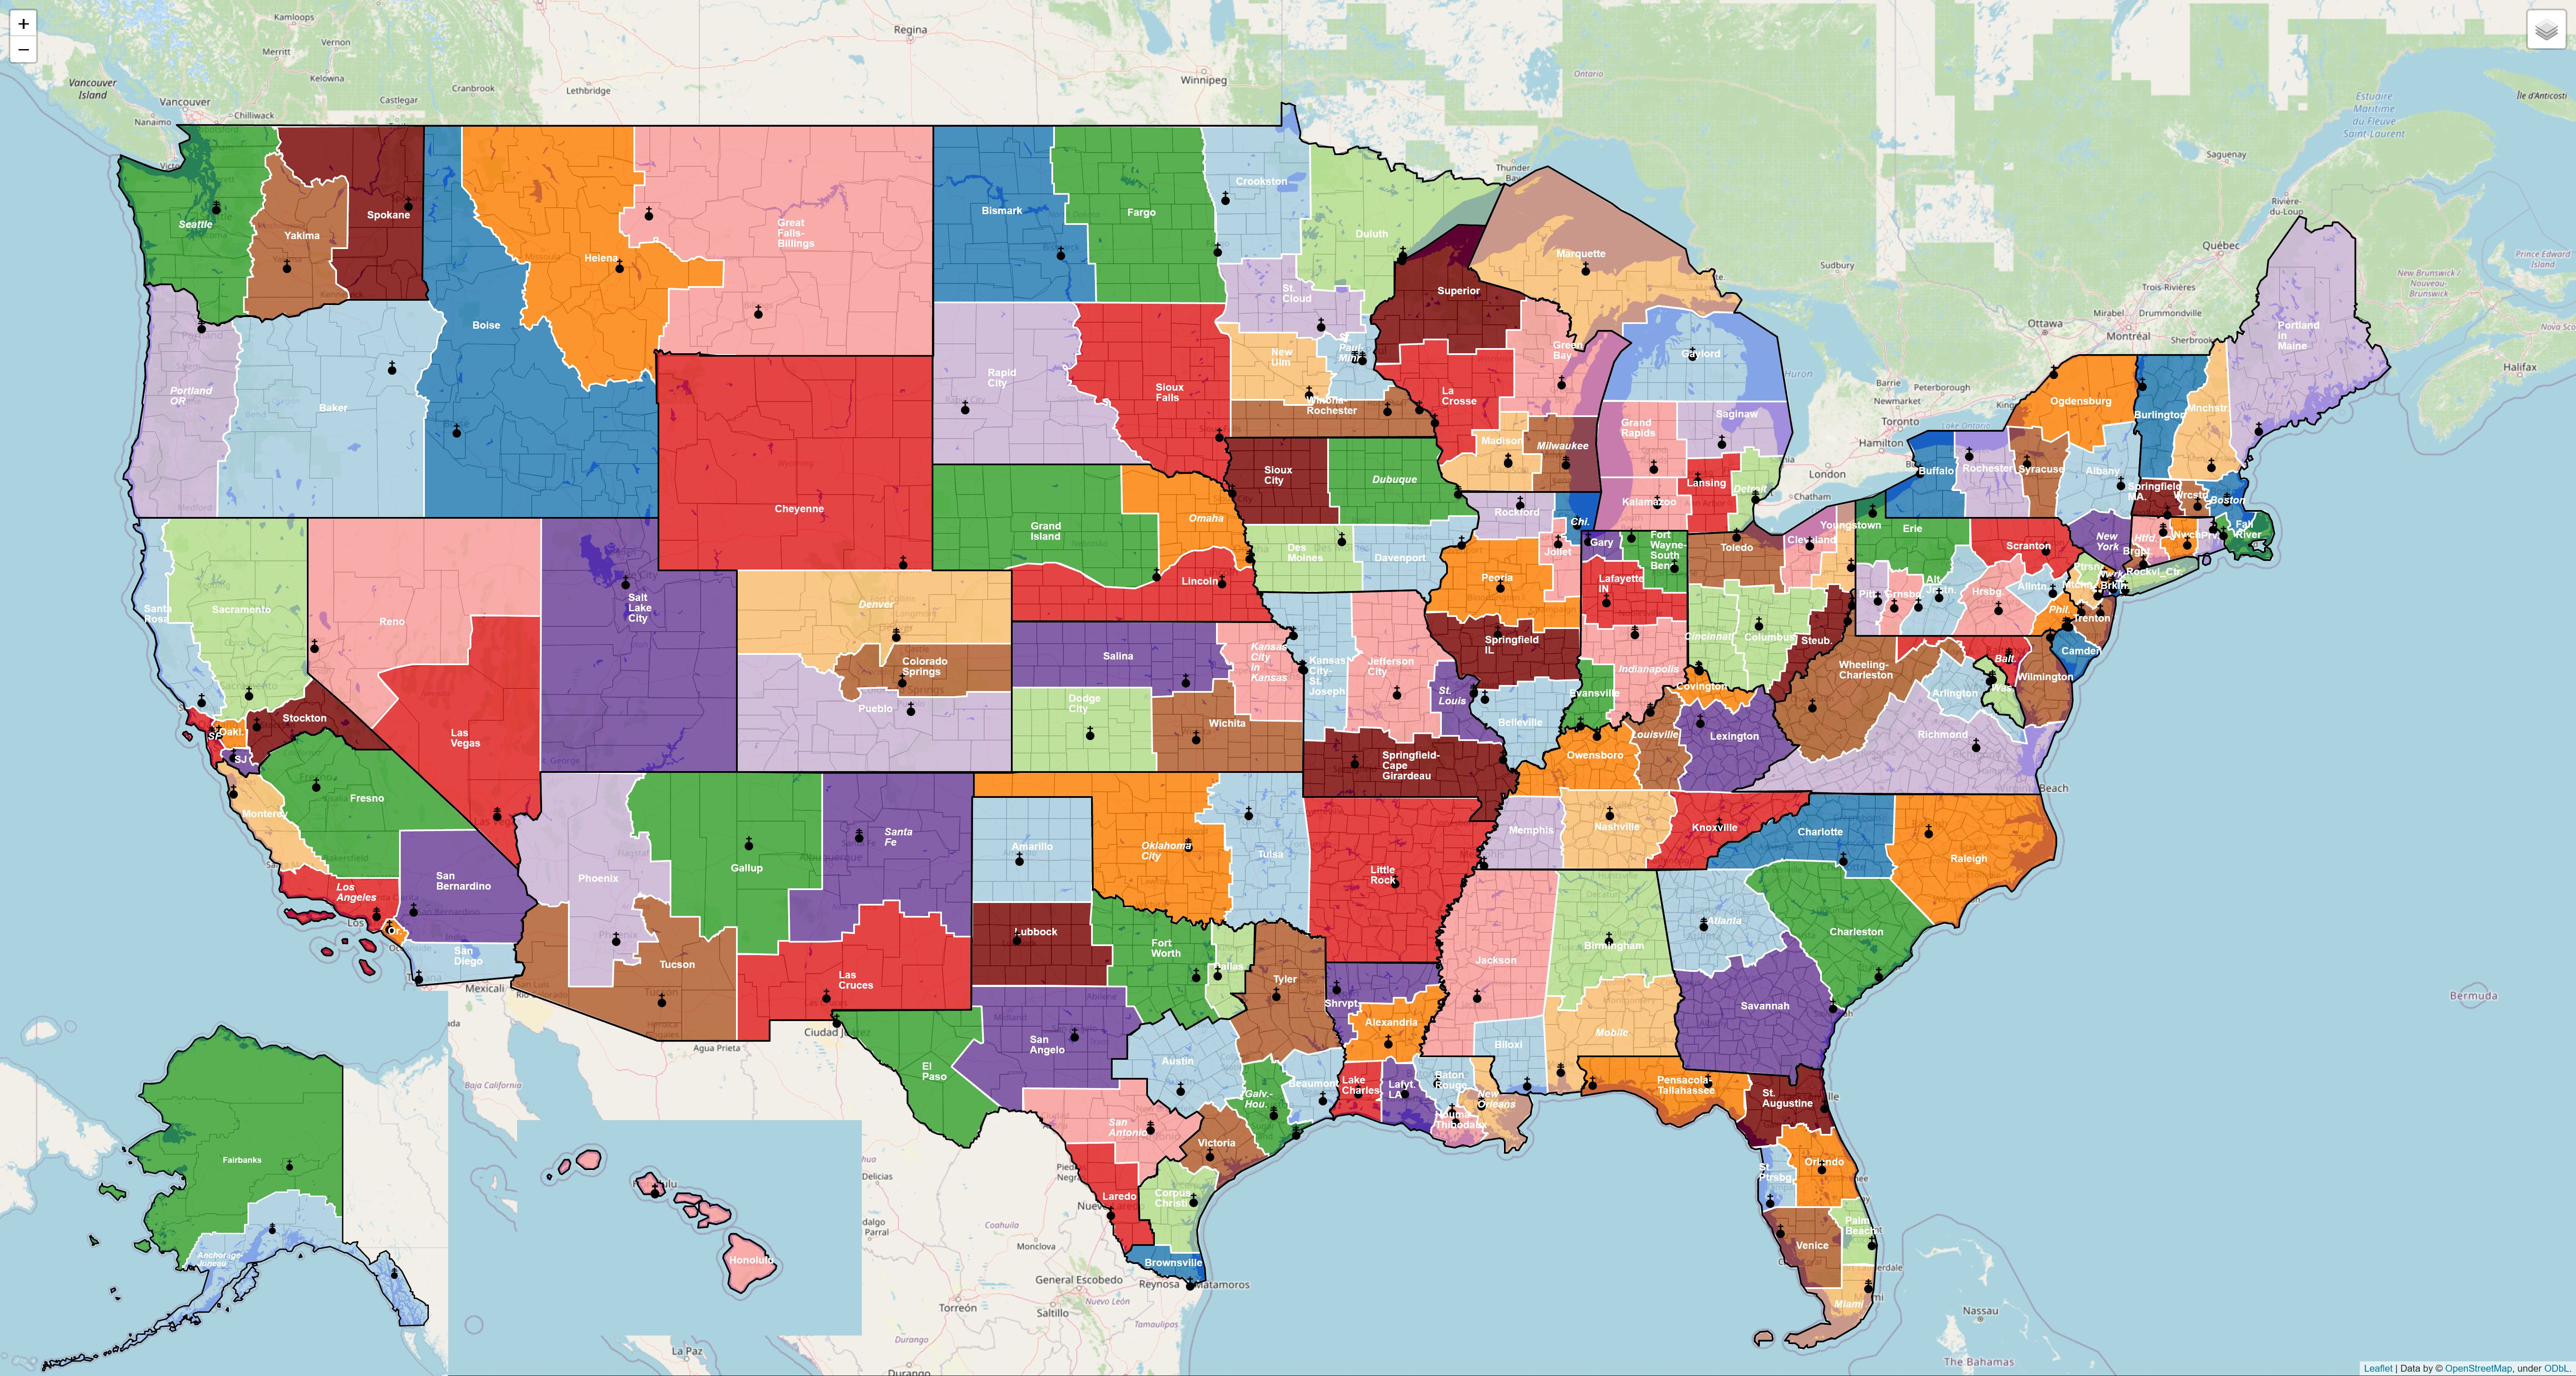

In [53]:
# The above line produces a screenshot of the final map,
# so create_map_screenshot doesn't need to be called there.
convert_png_to_smaller_jpg(png_folder = 'screenshots', 
png_image_name = 'revised_diocese_map_50_states.png', 
jpg_folder = 'smaller_screenshots', 
quality_factor = 80)

IPython.display.Image(
    filename='smaller_screenshots/'+'revised_diocese_map_50_states.jpg') 
# Based on https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html

## Creating simpler maps:

Finally, I'll create versions of these maps that lack either diocese names or cathedrals and create screenshots of them that show all 50 states. I made these maps for the [List of Catholic dioceses in the United States](https://en.wikipedia.org/wiki/List_of_Catholic_dioceses_in_the_United_States) and [List of Catholic cathedrals in the United States](https://en.wikipedia.org/wiki/List_of_Catholic_cathedrals_in_the_United_States) Wikipedia articles.

In [54]:
create_diocese_map(tile_option = None, include_cathedrals = False, 
save_path = 'revised_diocese_map_no_cathedrals_tileless')
create_map_screenshot(absolute_path_to_map_folder = 
    cwd, 
    map_name = 'revised_diocese_map_no_cathedrals_tileless.html', 
    screenshot_save_path = 'screenshots')

Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in diocese names:
Saving map:


In [55]:
add_alaska_and_hawaii(tile_option = None, 
starting_map_name = 'revised_diocese_map_no_cathedrals_tileless', 
include_cathedrals = False)

convert_png_to_smaller_jpg(png_folder = 'screenshots', 
png_image_name = 'revised_diocese_map_no_cathedrals_tileless_50_states.png', 
jpg_folder = 'smaller_screenshots', 
quality_factor = 80)

# IPython.display.Image(
# filename='smaller_screenshots/'+'revised_diocese_map_no_cathedrals_tileless_50_states.jpg') 
# # Based on https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html

Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in diocese names:
Saving map:
Opened
Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in diocese names:
Saving map:
Opened


In [56]:
create_diocese_map(tile_option = None, include_names = False, 
save_path = 'revised_diocese_map_no_names_tileless')
create_map_screenshot(absolute_path_to_map_folder = 
    cwd, 
    map_name = 'revised_diocese_map_no_names_tileless.html', 
    screenshot_save_path = 'screenshots')

Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in cathedrals:
Added 194 cathedrals to the map.
Saving map:


In [57]:
add_alaska_and_hawaii(tile_option = None, 
starting_map_name = 'revised_diocese_map_no_names_tileless', 
include_names = False)

Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in cathedrals:
Added 194 cathedrals to the map.
Saving map:
Opened
Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in cathedrals:
Added 194 cathedrals to the map.
Saving map:
Opened


In [58]:
convert_png_to_smaller_jpg(png_folder = 'screenshots', 
png_image_name = 'revised_diocese_map_no_names_tileless_50_states.png', 
jpg_folder = 'smaller_screenshots', 
quality_factor = 80)

# IPython.display.Image(
# filename='smaller_screenshots/'+'revised_diocese_map_no_names_tileless_50_states.jpg') 
# Based on https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html

# Creating a map without water boundaries:

This version of the map relies on the water boundaries provided by the tile provider rather than those in the boundaries file we imported earlier. This allows for smaller map sizes, which in turn makes it easier to host these maps on Google Sites.

In [59]:
create_diocese_map(include_water_bodies = False, 
    save_path = 'revised_diocese_map_no_water_bodies')

create_map_screenshot(absolute_path_to_map_folder = 
    cwd, 
    map_name = 'revised_diocese_map_no_water_bodies.html', 
    screenshot_save_path = 'screenshots')

add_alaska_and_hawaii(tile_option = None, 
starting_map_name = 'revised_diocese_map_no_water_bodies', 
include_cathedrals = True)

convert_png_to_smaller_jpg(png_folder = 'screenshots', 
png_image_name = 'revised_diocese_map_no_water_bodies_50_states.png', 
jpg_folder = 'smaller_screenshots', 
quality_factor = 80)

# IPython.display.Image(
# filename='smaller_screenshots/'+'revised_diocese_map_no_cathedrals_tileless_50_states.jpg') 
# # Based on https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html

Adding in counties:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in cathedrals:
Added 194 cathedrals to the map.
Adding in diocese names:
Saving map:
Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in cathedrals:
Added 194 cathedrals to the map.
Adding in diocese names:
Saving map:
Opened
Adding in counties:
Adding in bodies of water:
Adding in dioceses:
Adding in provinces:
Adding in tooltips:
Adding in cathedrals:
Added 194 cathedrals to the map.
Adding in diocese names:
Saving map:
Opened


That's all I have for this script! I hope you'll find the code helpful in your own mapping work.

In [60]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),
"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),
"second(s))") 
# Only meaningful when the program is run nonstop from start to finish

Completed run at Mon Apr  8 23:51:16 2024 (local time)
Total run time: 978.22 second(s) (16.0 minute(s) and 18.22 second(s))
